# Explore differential expression analysis results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from DE_analysis_utils import *

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'

## Pseudobulk expression profiles exploratory analysis

In [310]:
pbulk_adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.DE_pseudobulk.h5ad')
pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].copy()

# Normalize for plotting and PCA
sc.pp.normalize_total(pbulk_adata, target_sum=100000)
sc.pp.log1p(pbulk_adata)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/aligned_df.py:83: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


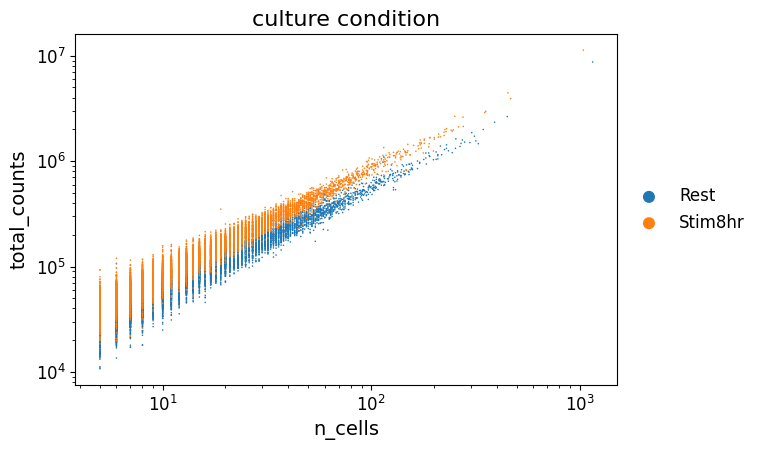

In [54]:
sc.pl.scatter(pbulk_adata,'n_cells', 'total_counts', show=False, color='culture_condition');
plt.yscale('log');
plt.xscale('log')

Subset to genes used for DE analysis

In [311]:
try:
    with open(f'{datadir}/DE_test_genes.txt', 'r') as f:
        de_test_genes = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(de_test_genes)} genes for DE testing")
except FileNotFoundError:
    raise(FileNotFoundError, f"Warning: DE test genes file not found at {datadir}/DE_test_genes.txt - run feature selection first.")

pbulk_adata = pbulk_adata[:, de_test_genes].copy()

Loaded 11036 genes for DE testing


In [312]:
pbulk_adata_stim = pbulk_adata[pbulk_adata.obs['culture_condition'] == 'Stim8hr']
pbulk_adata_rest = pbulk_adata[pbulk_adata.obs['culture_condition'] == 'Rest']

In [313]:
sc.pp.scale(pbulk_adata_stim)
sc.pp.scale(pbulk_adata_rest)
sc.pp.pca(pbulk_adata_rest)
sc.pp.pca(pbulk_adata_stim)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [65]:
pbulk_adata_rest.var_names = pbulk_adata_rest.var['gene_name'].values
pbulk_adata_stim.var_names = pbulk_adata_stim.var['gene_name'].values

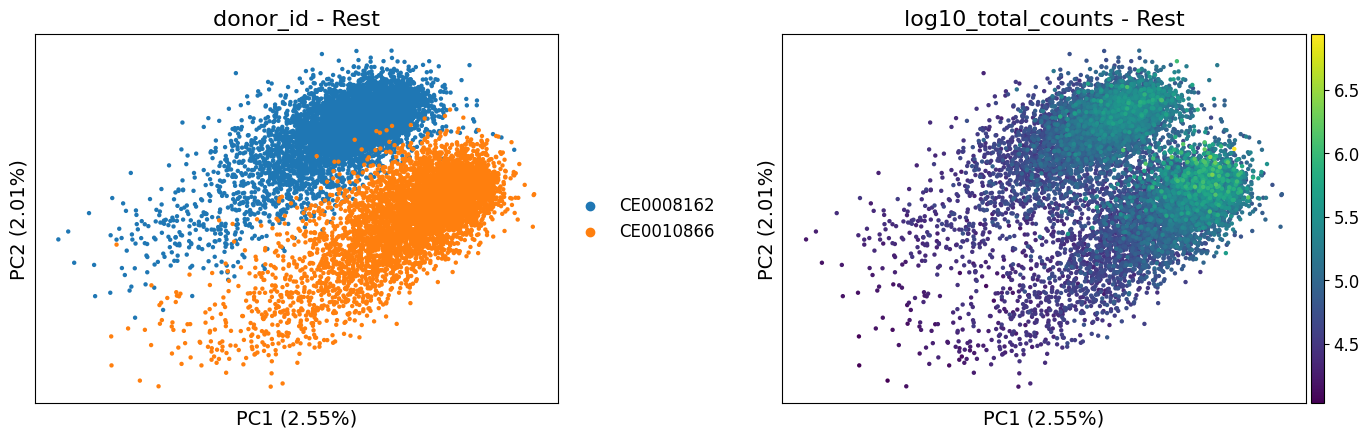

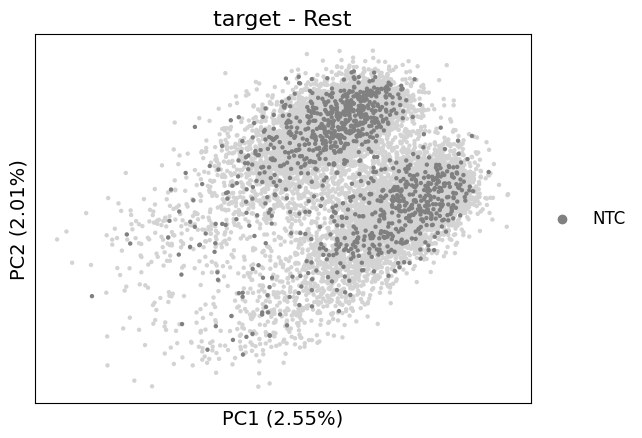

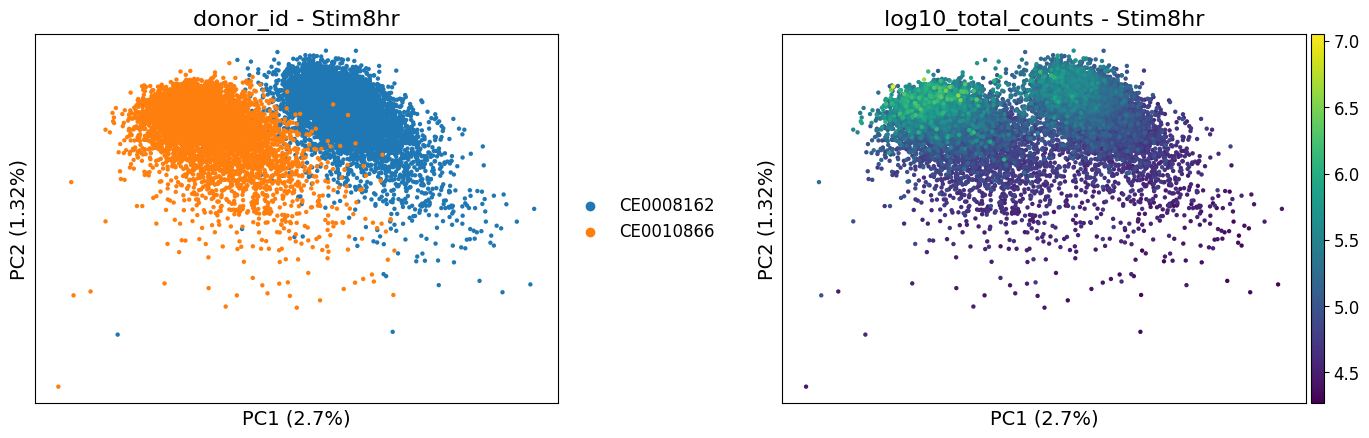

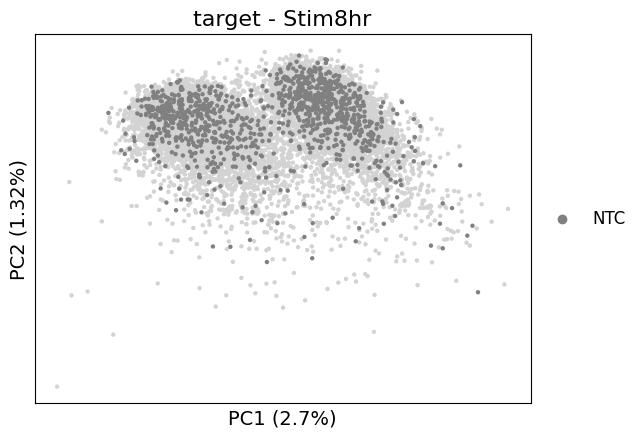

In [72]:
pbulk_adata_rest.obs['log10_total_counts'] = np.log10(pbulk_adata_rest.obs['total_counts']  )
pbulk_adata_stim.obs['log10_total_counts'] = np.log10(pbulk_adata_stim.obs['total_counts']  )

cols = ['donor_id', 'log10_total_counts']
sc.pl.pca(pbulk_adata_rest, color=cols, size=40, annotate_var_explained=True, ncols=3, title=[f"{x} - Rest" for x in cols], wspace=0.3)
sc.pl.pca(pbulk_adata_rest, color=['target'], groups=['NTC'], size=40, annotate_var_explained=True, ncols=3, title=[f"target - Rest" for x in cols], na_in_legend=False)
sc.pl.pca(pbulk_adata_stim, color=cols, size=40, annotate_var_explained=True, ncols=3, title=[f"{x} - Stim8hr" for x in cols], wspace=0.3)
sc.pl.pca(pbulk_adata_stim, color=['target'], groups=['NTC'], size=40, annotate_var_explained=True, ncols=3, title=[f"target - Stim8hr" for x in cols], na_in_legend=False)

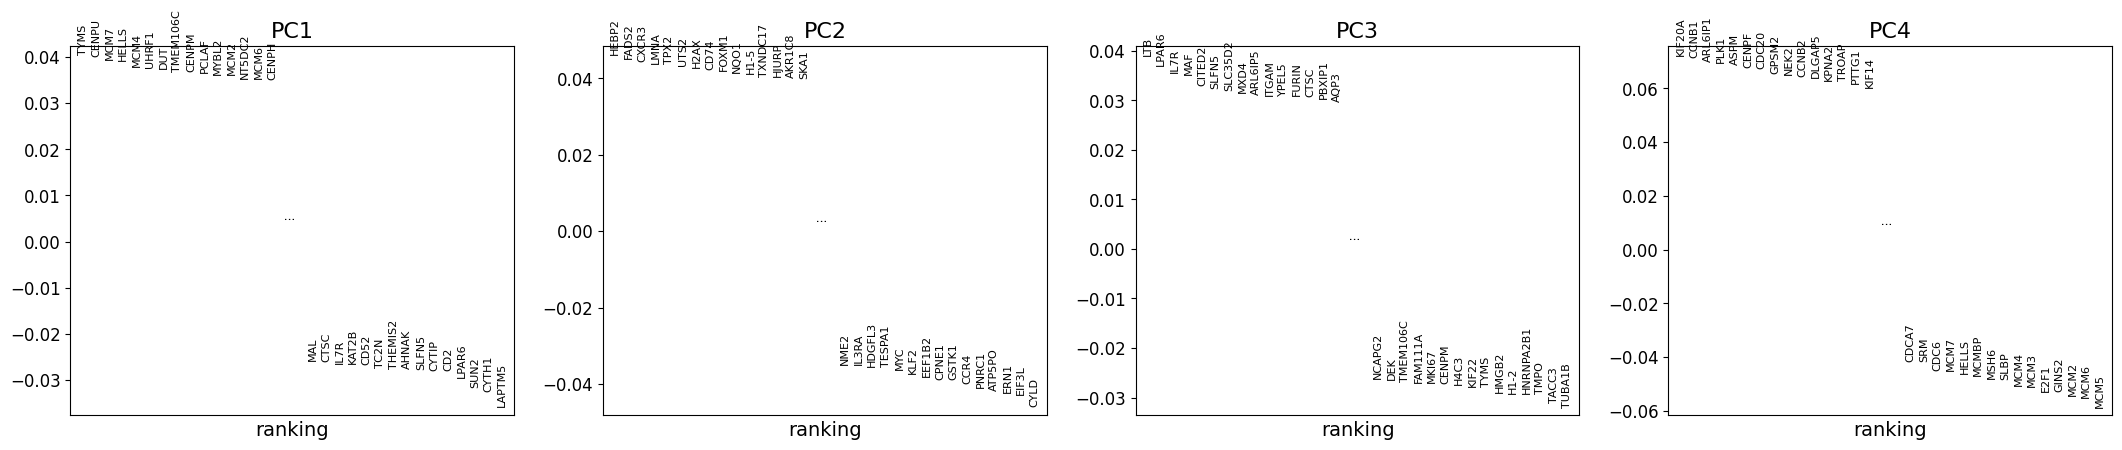

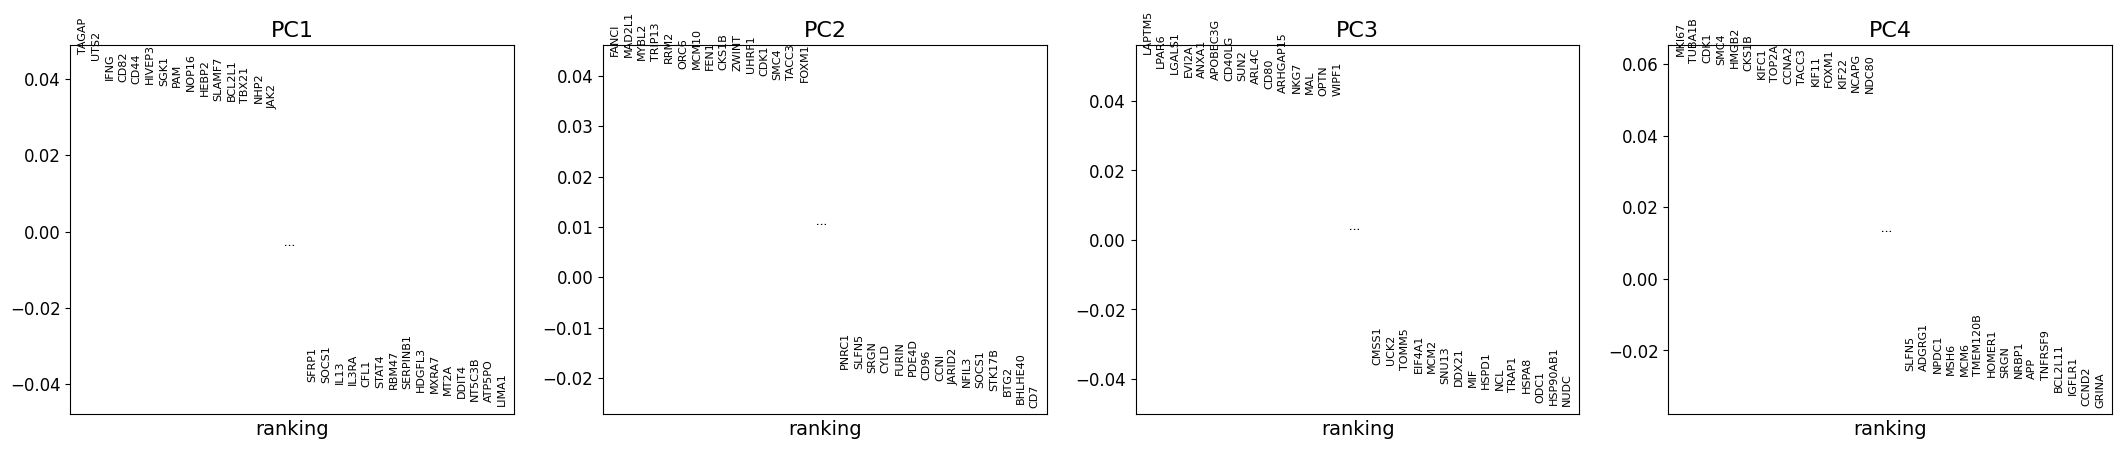

In [73]:
sc.pl.pca_loadings(pbulk_adata_rest, components=[1,2,3,4])
sc.pl.pca_loadings(pbulk_adata_stim, components=[1,2,3,4])

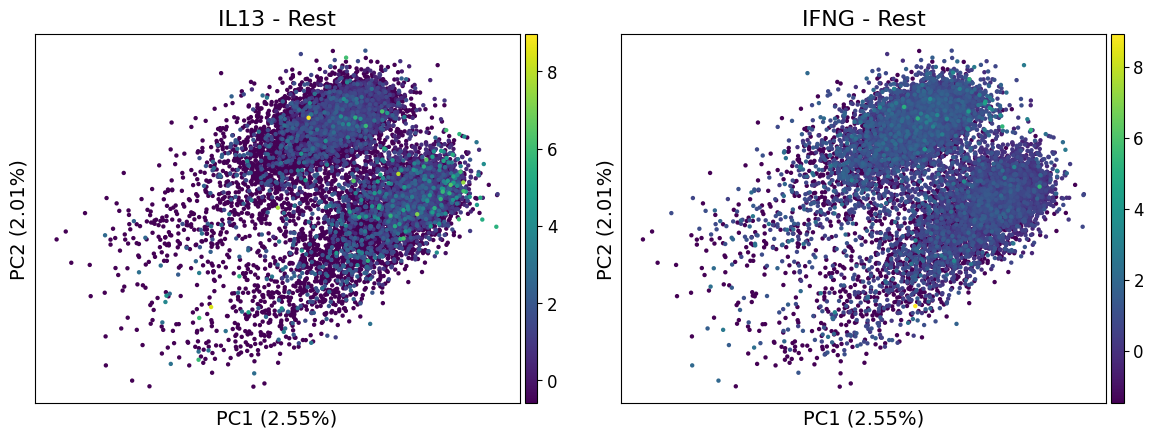

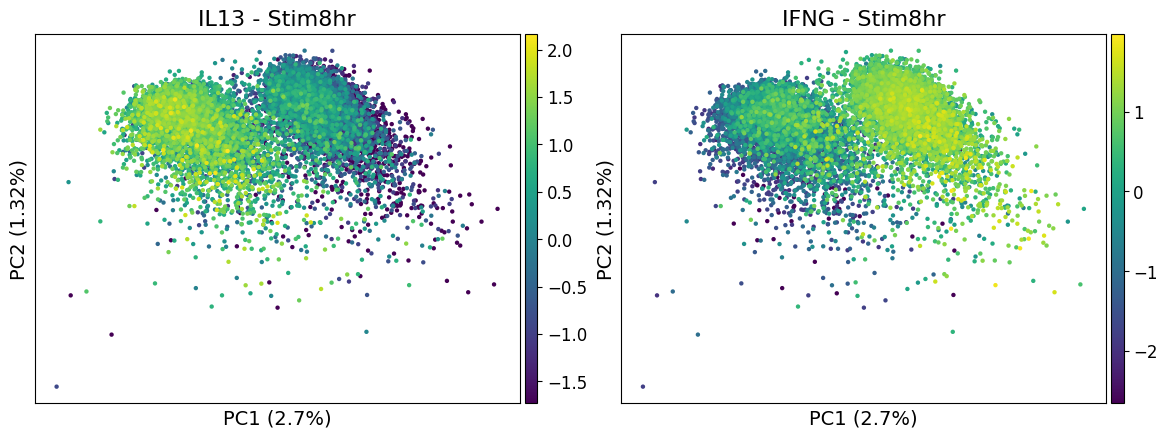

In [77]:
cols = ['IL13', 'IFNG']
sc.pl.pca(pbulk_adata_rest, color=cols, size=40, annotate_var_explained=True, ncols=3, title=[f"{x} - Rest" for x in cols], wspace=0.1)
sc.pl.pca(pbulk_adata_stim, color=cols, size=40, annotate_var_explained=True, ncols=3, title=[f"{x} - Stim8hr" for x in cols], wspace=0.1)


## Compare alternative DE designs

Accounting for donor effect or not

In [6]:
adata_de_nodonor = sc.read_h5ad(datadir + f'/DE_results_no_donor/{experiment_name}.merged_DE_results.h5ad')
adata_de_wdonor = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [7]:
# de_stats_nodonor = get_de_stats(adata_de_nodonor, effect_col='MASH_PosteriorMean', signif_col='MASH_lfsr', alpha=0.1)
# de_stats_wdonor = get_de_stats(adata_de_wdonor, effect_col='MASH_PosteriorMean', signif_col='MASH_lfsr', alpha=0.1)
de_stats_nodonor = get_de_stats(adata_de_nodonor, effect_col='log_fc', signif_col='adj_p_value', alpha=0.1)
de_stats_wdonor = get_de_stats(adata_de_wdonor, effect_col='log_fc', signif_col='adj_p_value', alpha=0.1)

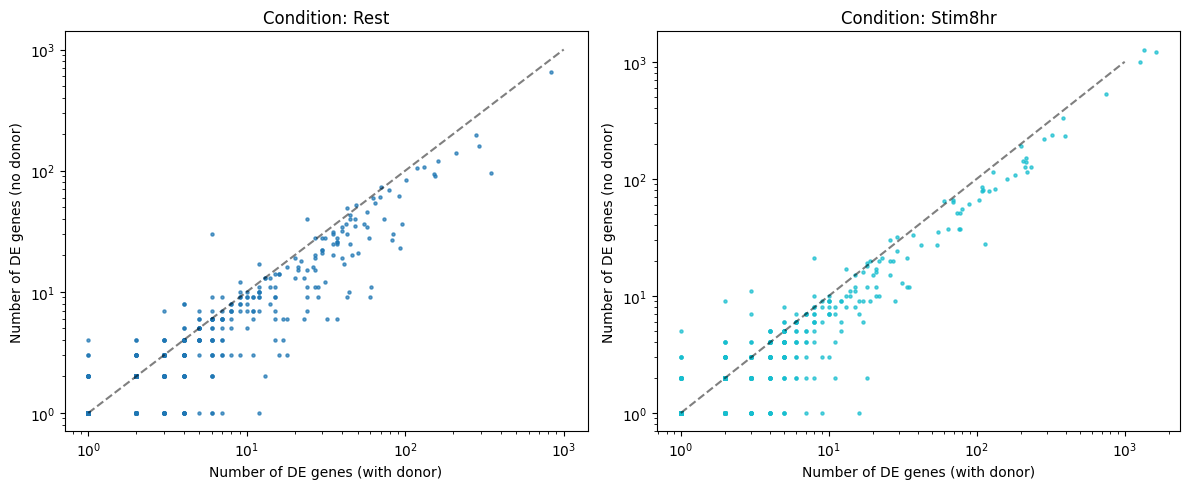

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
conditions = de_stats_wdonor.index.str.split('_').str[-1].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(conditions)))
for i, condition in enumerate(conditions):
    mask = de_stats_wdonor.index.str.endswith(condition)
    axes[i].plot([1, 1000], [1, 1000], 'k--', alpha=0.5)
    axes[i].scatter(de_stats_wdonor.loc[mask, 'n_total_de_genes'], 
                    de_stats_nodonor.loc[mask, 'n_total_de_genes'], 
                    s=5, alpha=0.7, color=colors[i])
    
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('Number of DE genes (with donor)')
    axes[i].set_ylabel('Number of DE genes (no donor)')
    axes[i].set_title(f'Condition: {condition}')

plt.tight_layout()

In [8]:
print(sum(de_stats_nodonor.sort_values('n_total_de_genes', ascending=False)['n_total_de_genes'] == 0))
print(sum(de_stats_wdonor.sort_values('n_total_de_genes', ascending=False)['n_total_de_genes'] == 0))

combined_stats = pd.concat([de_stats_nodonor, de_stats_wdonor], axis=1, keys=['nodonor', 'wdonor'])

# Find targets where n_total_de_genes is 0 for nodonor and > 0 with donor
targets_gained_with_donor = combined_stats[
    (combined_stats['nodonor', 'n_total_de_genes'] == 0) & 
    (combined_stats['wdonor', 'n_total_de_genes'] > 0)
]

more_power_pairs = list(zip(targets_gained_with_donor['wdonor']['target_name'], targets_gained_with_donor['wdonor']['condition']))

4252
4052


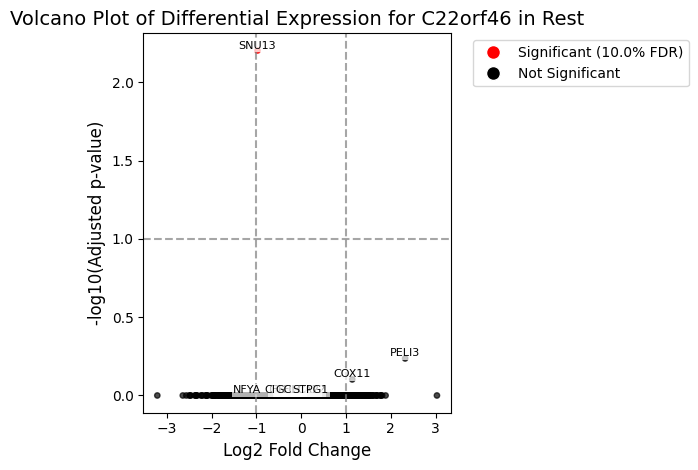

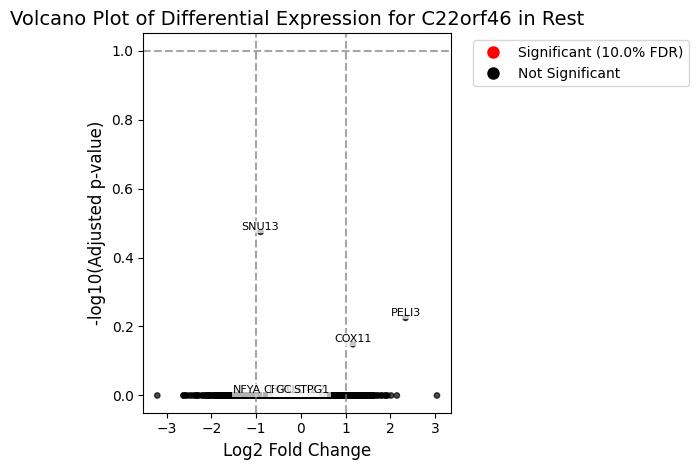

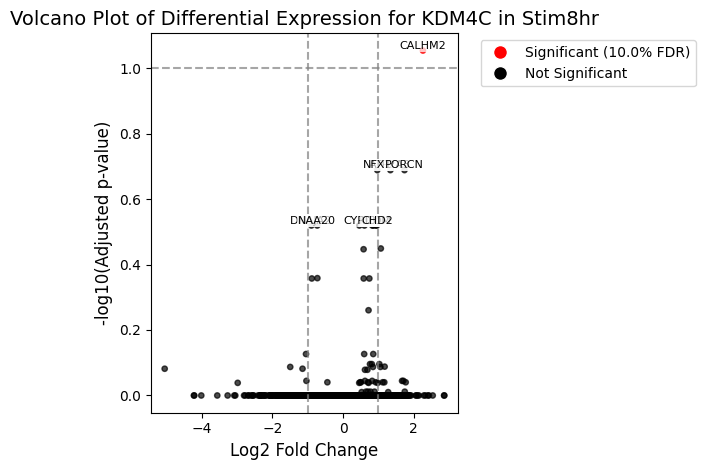

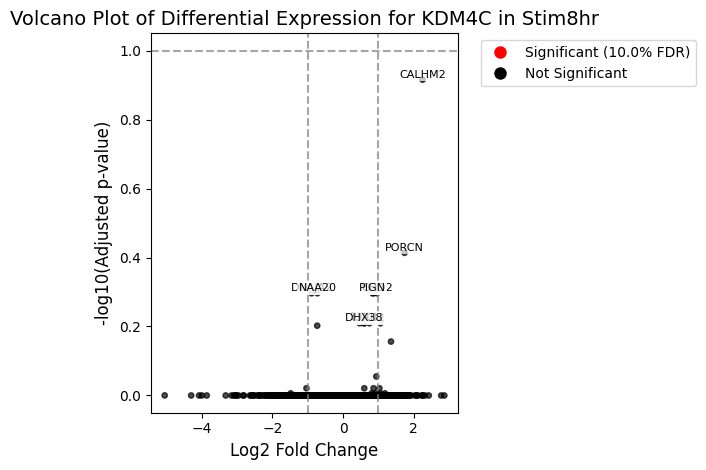

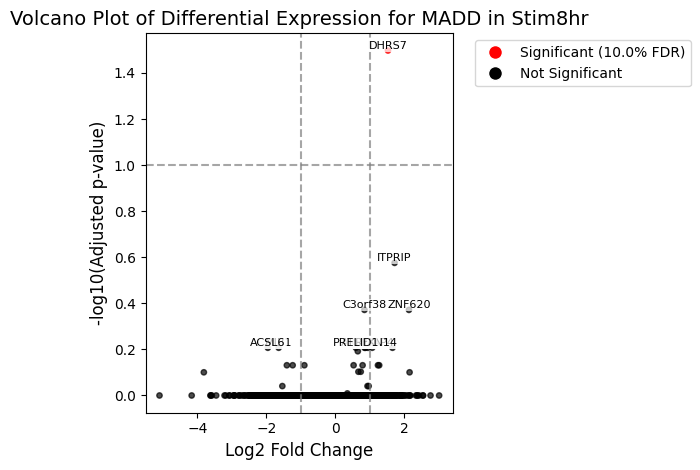

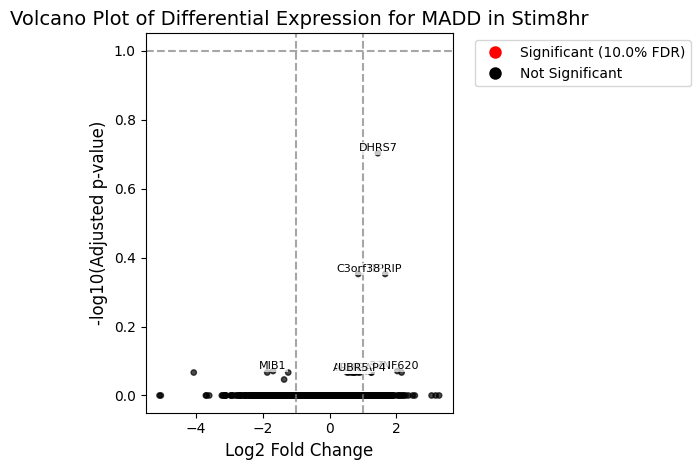

In [9]:
pl_pairs = more_power_pairs[0:3]

for t, cond in pl_pairs:
    fig, pl_df1 = plot_volcano(adata_de_wdonor, t, cond, figsize=None)
    fig.show()
    fig, pl_df2 = plot_volcano(adata_de_nodonor, t, cond, figsize=None)
    fig.show()
    

In [10]:
adata_de_nodonor.layers['zscore'] = adata_de_nodonor.layers['log_fc'] / adata_de_nodonor.layers['lfcSE']
adata_de_nodonor.layers['zscore'][np.where(adata_de_nodonor.layers['zscore'] > 50)] = 50
adata_de_wdonor.layers['zscore'] = adata_de_wdonor.layers['log_fc'] / adata_de_wdonor.layers['lfcSE']
adata_de_wdonor.layers['zscore'][np.where(adata_de_wdonor.layers['zscore'] > 50)] = 50

In [11]:
ontarget_nodonor = get_ontarget_effect(adata_de_nodonor)
ontarget_wdonor = get_ontarget_effect(adata_de_wdonor)

In [12]:
tot_targets = ontarget_nodonor.shape[0]
alpha_thresh =  [0.01, 0.05, 0.1, 0.2, 0.3]

# Create lists to store all data points
alpha_values = []
proportion_values = []
shrinkage_status = []
donor_status = []

# Process no donor data
for i, alpha in enumerate(alpha_thresh):
    # Before shrinkage
    prop = (ontarget_nodonor['adj_p_value'] < alpha).value_counts().loc[True]/tot_targets
    alpha_values.append(alpha)
    proportion_values.append(prop)
    shrinkage_status.append('Before shrinkage')
    donor_status.append('~ n_cells + target')
    
    # After shrinkage
    prop = (ontarget_nodonor['MASH_lfsr'] < alpha).value_counts().loc[True]/tot_targets
    alpha_values.append(alpha)
    proportion_values.append(prop)
    shrinkage_status.append('After shrinkage')
    donor_status.append('~ n_cells + target')

# Process with donor data
for i, alpha in enumerate(alpha_thresh):
    # Before shrinkage
    prop = (ontarget_wdonor['adj_p_value'] < alpha).value_counts().loc[True]/tot_targets
    alpha_values.append(alpha)
    proportion_values.append(prop)
    shrinkage_status.append('Before shrinkage')
    donor_status.append('~ n_cells + donor + target')
    
    # After shrinkage
    prop = (ontarget_wdonor['MASH_lfsr'] < alpha).value_counts().loc[True]/tot_targets
    alpha_values.append(alpha)
    proportion_values.append(prop)
    shrinkage_status.append('After shrinkage')
    donor_status.append('~ n_cells + donor + target')

# Create the long-format dataframe
ontarget_effects_df = pd.DataFrame({
    'alpha_threshold': alpha_values,
    'proportion_significant': proportion_values,
    'shrinkage status': shrinkage_status,
    'DE design': donor_status
})

In [45]:
ontarget_effects_df[(ontarget_effects_df['DE design'] == '~ n_cells + donor + target') & (ontarget_effects_df.alpha_threshold == 0.1)]

alpha_threshold  proportion_significant  shrinkage status  \
14              0.1                0.186639  Before shrinkage   
15              0.1                0.249163   After shrinkage   

                     DE design  
14  ~ n_cells + donor + target  
15  ~ n_cells + donor + target

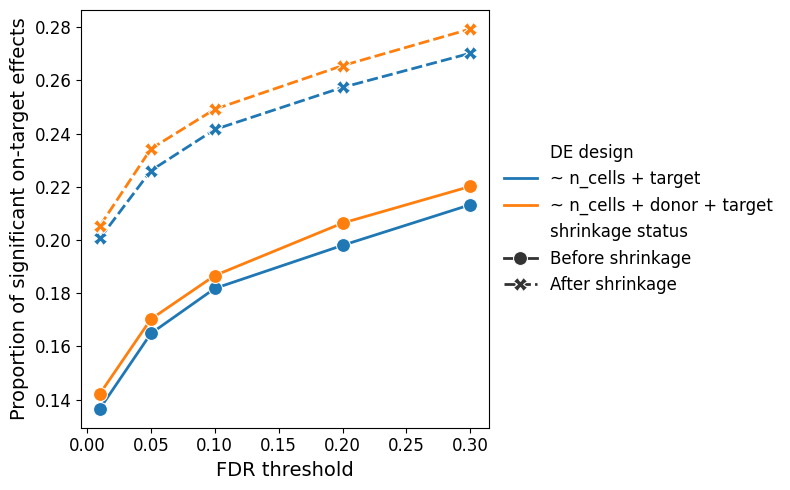

In [13]:
plt.figure(figsize=(8,5))
sns.lineplot(data=ontarget_effects_df, x='alpha_threshold', y='proportion_significant', 
             style='shrinkage status', hue='DE design', markers=True, dashes=True, 
             markersize=10, linewidth=2)
plt.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)
plt.xlabel('FDR threshold', fontsize=14);
plt.ylabel('Proportion of significant on-target effects', fontsize=14);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.tight_layout()

In [15]:
de_genes_stats_nodonor = get_de_stats(adata_de_nodonor, effect_col='log_fc', signif_col='adj_p_value', alpha=0.1, axis='genes')
de_genes_stats_wdonor = get_de_stats(adata_de_wdonor, effect_col='log_fc', signif_col='adj_p_value', alpha=0.1, axis='genes')
de_genes_stats_wdonor.head()

gene_id gene_name  n_up_targets  n_down_targets  \
ENSG00000000419  ENSG00000000419      DPM1             3               1   
ENSG00000000460  ENSG00000000460  C1orf112             1               0   
ENSG00000000971  ENSG00000000971       CFH             1               0   
ENSG00000001036  ENSG00000001036     FUCA2             1               0   
ENSG00000001084  ENSG00000001084      GCLC             4               0   

                 n_total_de_targets  
ENSG00000000419                   4  
ENSG00000000460                   1  
ENSG00000000971                   1  
ENSG00000001036                   1  
ENSG00000001084                   4

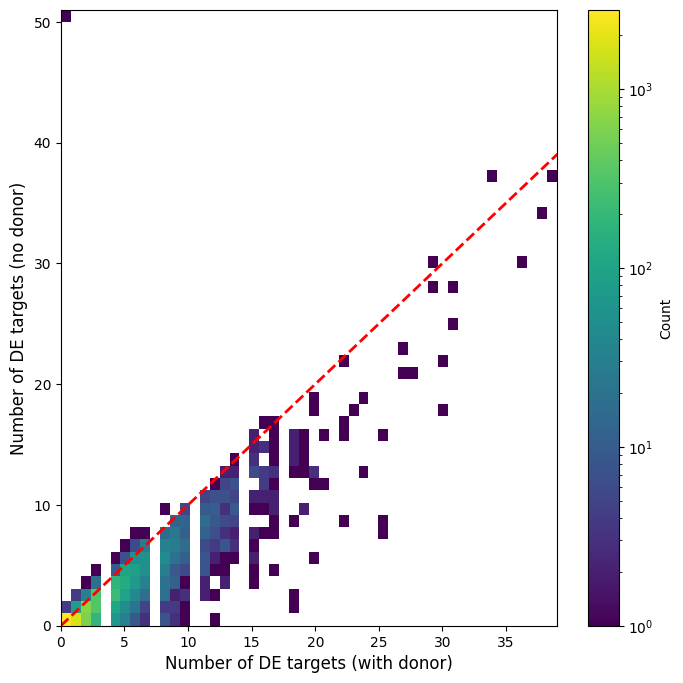

In [19]:
# Create a 2D histogram
plt.figure(figsize=(8, 8))
plt.hist2d(de_genes_stats_wdonor['n_total_de_targets'], de_genes_stats_nodonor['n_total_de_targets'], 
           bins=50, cmap='viridis', norm=matplotlib.colors.LogNorm())

# Add a diagonal line
max_val = max(de_genes_stats_wdonor['n_total_de_targets'].max(), de_genes_stats_nodonor['n_total_de_targets'].max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

# Add labels
plt.xlabel('Number of DE targets (with donor)', fontsize=12)
plt.ylabel('Number of DE targets (no donor)', fontsize=12)
plt.colorbar(label='Count')

In [44]:
de_genes_stats_wdonor[de_genes_stats_wdonor['n_total_de_targets'] < de_genes_stats_nodonor['n_total_de_targets']-1]

gene_id gene_name  n_up_targets  n_down_targets  \
ENSG00000100629  ENSG00000100629    CEP128             1               0   
ENSG00000111364  ENSG00000111364     DDX55             0               0   
ENSG00000112115  ENSG00000112115     IL17A             0               0   
ENSG00000120725  ENSG00000120725      SIL1             1               1   
ENSG00000122378  ENSG00000122378    PRXL2A             0               0   
ENSG00000125656  ENSG00000125656      CLPP             0               0   
ENSG00000128656  ENSG00000128656      CHN1             6               0   
ENSG00000132600  ENSG00000132600     PRMT7             1               0   
ENSG00000147174  ENSG00000147174      GCNA             1               0   
ENSG00000160193  ENSG00000160193      WDR4             1               0   
ENSG00000162892  ENSG00000162892      IL24             0               0   
ENSG00000164399  ENSG00000164399       IL3             9              25   
ENSG00000172354  ENSG00000172354      GNB2             3               2   
ENSG00000187837  ENSG00000187837      H1-2             0               8   
ENSG00000213983  ENSG00000213983     AP1G2             2               2   
ENSG00000232810  ENSG00000232810       TNF             2               1   

                 n_total_de_targets  
ENSG00000100629                   1  
ENSG00000111364                   0  
ENSG00000112115                   0  
ENSG00000120725                   2  
ENSG00000122378                   0  
ENSG00000125656                   0  
ENSG00000128656                   6  
ENSG00000132600                   1  
ENSG00000147174                   1  
ENSG00000160193                   1  
ENSG00000162892                   0  
ENSG00000164399                  34  
ENSG00000172354                   5  
ENSG00000187837                   8  
ENSG00000213983                   4  
ENSG00000232810                   3

In [15]:
g = 'TNF'
df = get_DE_results_long(adata_de=adata_de_nodonor, genes=[g])
df[df['adj_p_value'] < 0.1].sort_values('log_fc')


index             gene    log_fc    zscore  \
874      ENSG00000100201_Rest  ENSG00000232810  1.155834  3.843473   
801   ENSG00000094916_Stim8hr  ENSG00000232810  1.825437  4.252721   
4813  ENSG00000174004_Stim8hr  ENSG00000232810  2.144392  4.370861   
3661  ENSG00000157657_Stim8hr  ENSG00000232810  2.232960  4.352953   
1406     ENSG00000109320_Rest  ENSG00000232810  2.942940  7.844147   

       adj_p_value  significant gene_name culture_condition  target_contrast  \
874   5.785834e-02         True       TNF              Rest  ENSG00000100201   
801   3.935709e-02         True       TNF           Stim8hr  ENSG00000094916   
4813  8.846834e-02         True       TNF           Stim8hr  ENSG00000174004   
3661  6.269861e-02         True       TNF           Stim8hr  ENSG00000157657   
1406  7.788756e-12         True       TNF              Rest  ENSG00000109320   

     target_contrast_gene_name  
874                      DDX17  
801                       CBX5  
4813                     NRROS  
3661                    ZNF618  
1406                     NFKB1

In [16]:
df = get_DE_results_long(adata_de=adata_de_wdonor, genes=[g])
df[df['adj_p_value'] < 0.1].sort_values('log_fc')

index             gene    log_fc    zscore   adj_p_value  \
1894  ENSG00000119231_Rest  ENSG00000232810 -1.213859 -2.771635  6.650155e-02   
874   ENSG00000100201_Rest  ENSG00000232810  1.209506  4.270133  1.271631e-02   
1406  ENSG00000109320_Rest  ENSG00000232810  3.211740  9.151481  1.023427e-16   

      significant gene_name culture_condition  target_contrast  \
1894         True       TNF              Rest  ENSG00000119231   
874          True       TNF              Rest  ENSG00000100201   
1406         True       TNF              Rest  ENSG00000109320   

     target_contrast_gene_name  
1894                     SENP5  
874                      DDX17  
1406                     NFKB1

/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/3_DE_analysis/DE_analysis_utils.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df[target_name_col] = pl_df[target_name_col].astype(str)
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/3_DE_analysis/DE_analysis_utils.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = pl_df[pl_df['culture_condition'] == condition].groupby(


<Axes: title={'center': 'TNF expression by NFKB1 vs NTC in Stim8hr'}, xlabel='perturbed_gene_name', ylabel='TNF expression'>

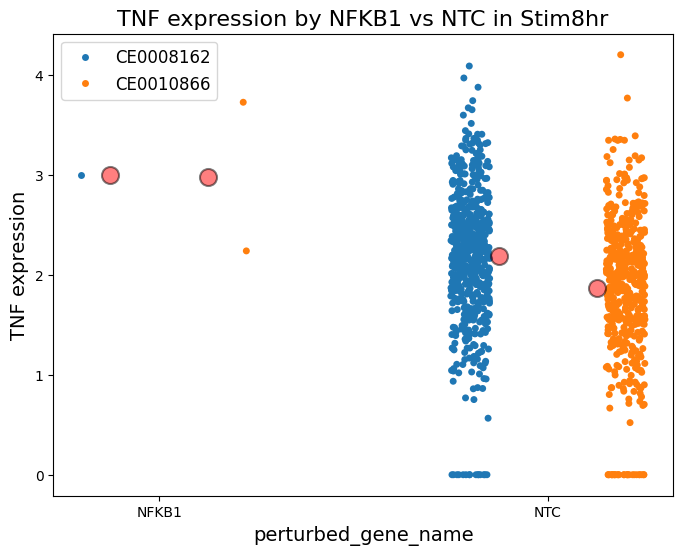

In [17]:
plot_gene_expression_by_target(pbulk_adata, target_id='NFKB1', gene_id=g, hue='donor_id', target_name_col='perturbed_gene_name', condition='Stim8hr')

## Read best DE results

In [5]:
adata_de_wdonor = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [6]:
adata_de = adata_de_wdonor

# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

In [7]:
adata_de.obs['target_contrast'].nunique()

3242

## Variability between DE analysis batches/chunks

In [8]:
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
base_mean_stim = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T

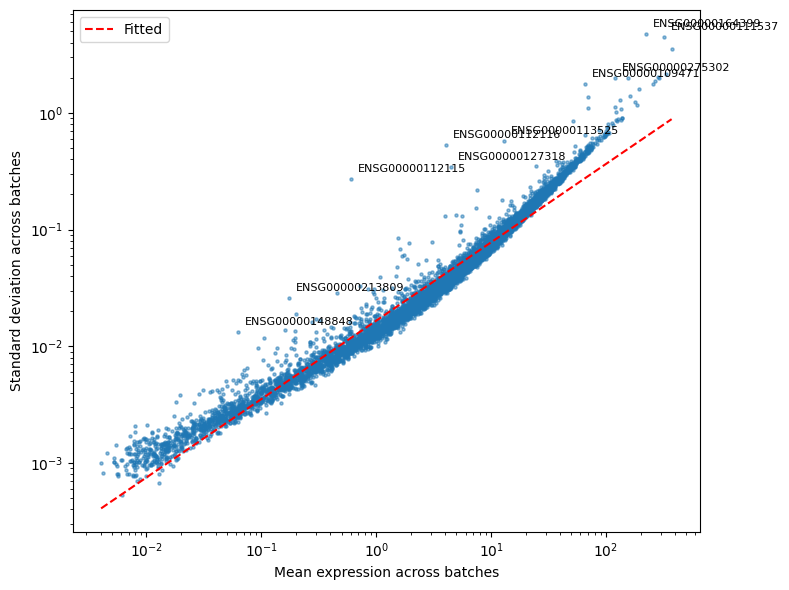

In [9]:
# Calculate mean and standard deviation across batches
mean_values = base_mean_stim.mean(1)
std_values = base_mean_stim.std(1)

# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, std_values, alpha=0.5, s=5)

# Fit a power law relationship between mean and std (std ~ mean^alpha)
# Use log-log space for linear fitting
valid_points = (mean_values > 0) & (std_values > 0)
log_mean = np.log(mean_values[valid_points])
log_std = np.log(std_values[valid_points])
fit = np.polyfit(log_mean, log_std, 1)
alpha = fit[0]  # Power law exponent
const = np.exp(fit[1])  # Multiplicative constant

# Generate fitted line
x_range = np.logspace(np.log10(mean_values.min()), np.log10(mean_values.max()), 100)
fitted_std = const * (x_range ** alpha)
plt.plot(x_range, fitted_std, 'r--', 
         label=f'Fitted')

# Identify outliers based on fitted relationship
expected_std = const * (mean_values ** alpha)
outliers = std_values > (expected_std * 2)  # Points with std > 2x expected
outlier_indices = np.where(outliers)[0]

# Annotate top 10 outliers
if len(outlier_indices) > 0:
    # Sort outliers by deviation from expected
    deviation = std_values[outliers] / expected_std[outliers]
    top_outliers = outlier_indices[np.argsort(deviation)[-10:]]
    
    for idx in top_outliers:
        gene_name = base_mean_stim.index[idx]
        plt.annotate(gene_name, 
                    (mean_values.iloc[idx], std_values.iloc[idx]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean expression across batches')
plt.ylabel('Standard deviation across batches')
plt.legend()
plt.tight_layout()


In [10]:
adata_de.var.iloc[pd.Series(np.where(np.isnan(adata_de.layers['adj_p_value']))[1]).value_counts().index][0:20]

gene_ids gene_name     mt  n_signif_effects_Rest  \
ENSG00000112115  ENSG00000112115     IL17A  False                      0   
ENSG00000112116  ENSG00000112116     IL17F  False                      0   
ENSG00000126562  ENSG00000126562      WNK4  False                      0   
ENSG00000204103  ENSG00000204103      MAFB  False                      0   
ENSG00000108830  ENSG00000108830      RND2  False                      0   
ENSG00000119547  ENSG00000119547   ONECUT2  False                      0   
ENSG00000100302  ENSG00000100302     RASD2  False                      0   
ENSG00000139910  ENSG00000139910     NOVA1  False                      0   
ENSG00000021826  ENSG00000021826      CPS1  False                      0   
ENSG00000152315  ENSG00000152315    KCNK13  False                      0   
ENSG00000127863  ENSG00000127863  TNFRSF19  False                      0   
ENSG00000157734  ENSG00000157734     SNX22  False                      0   
ENSG00000187068  ENSG00000187068   C3orf70  False                      0   
ENSG00000146006  ENSG00000146006    LRRTM2  False                      0   
ENSG00000186522  ENSG00000186522  SEPTIN10  False                      0   
ENSG00000164746  ENSG00000164746   C7orf57  False                      0   
ENSG00000102302  ENSG00000102302      FGD1  False                      0   
ENSG00000167641  ENSG00000167641  PPP1R14A  False                      0   
ENSG00000164287  ENSG00000164287    CDC20B  False                      0   
ENSG00000089199  ENSG00000089199      CHGB  False                      0   

                 n_mash_signif_effects_Rest  n_signif_effects_Stim8hr  \
ENSG00000112115                           0                         0   
ENSG00000112116                           0                         0   
ENSG00000126562                           0                         0   
ENSG00000204103                           0                         0   
ENSG00000108830                           0                         0   
ENSG00000119547                           0                         0   
ENSG00000100302                           0                         0   
ENSG00000139910                           0                         0   
ENSG00000021826                           0                         0   
ENSG00000152315                           0                         0   
ENSG00000127863                           0                         0   
ENSG00000157734                           0                         0   
ENSG00000187068                           0                         0   
ENSG00000146006                           0                         0   
ENSG00000186522                           0                         0   
ENSG00000164746                           0                         0   
ENSG00000102302                           0                         0   
ENSG00000167641                           0                         0   
ENSG00000164287                           0                         0   
ENSG00000089199                           0                         0   

                 n_mash_signif_effects_Stim8hr  
ENSG00000112115                              0  
ENSG00000112116                              0  
ENSG00000126562                              0  
ENSG00000204103                              0  
ENSG00000108830                              0  
ENSG00000119547                              0  
ENSG00000100302                              0  
ENSG00000139910                              0  
ENSG00000021826                              0  
ENSG00000152315                              0  
ENSG00000127863                              0  
ENSG00000157734                              0  
ENSG00000187068                              0  
ENSG00000146006                              0  
ENSG00000186522                              0  
ENSG00000164746                              0  
ENSG00000102302                              0  
ENSG0000016

In [11]:
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1)

adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim.mean(1)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim.std(1)

### Compare estimates of confounder effects 

In [27]:
de_results_dir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/DE_results_all_confounders/tmp/'
de_results_files = glob.glob(de_results_dir + 'DE_results_confounders*.csv.gz')

# Create empty list to store dataframes
dfs = []

# Read and process each file
for file in tqdm(de_results_files, desc="Processing DE result files"):
    df = pd.read_csv(file, compression='gzip', index_col=0)
    df['chunk'] = file.split('.chunk_')[1].split('.')[0]
    df['condition'] = file.split('.')[1]
    dfs.append(df)

# Concatenate all dataframes into one
all_de_results = pd.concat(dfs, axis=0)

Processing DE result files: 100%|██████████| 130/130 [00:11<00:00, 11.07it/s]


/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


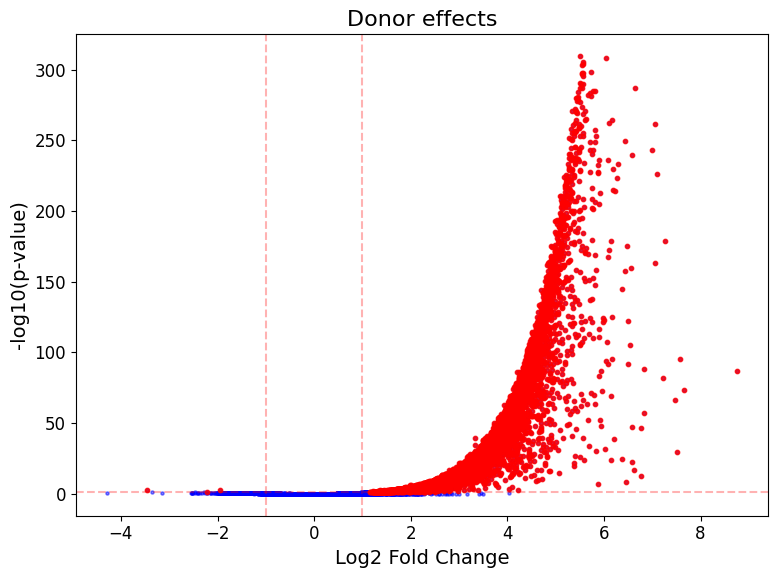

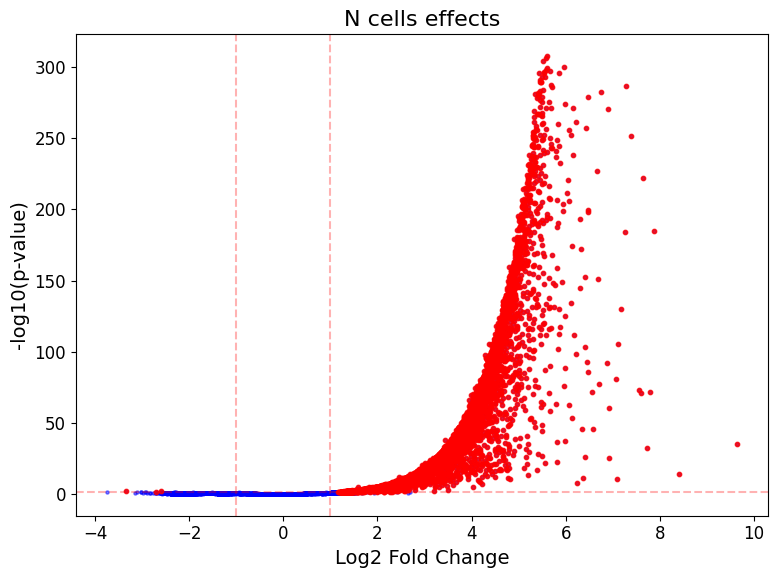

In [28]:
# Create a volcano plot for non-cell-count effects
plt.figure(figsize=(8, 6))
non_count_effects = all_de_results[(all_de_results.contrast != 'log10_n_cells') & (all_de_results.chunk == '0')]
plt.scatter(non_count_effects['log_fc'], -np.log10(non_count_effects['p_value']), 
            alpha=0.5, s=5, color='blue')

# Add threshold lines
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.3)
plt.axvline(x=-1, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.3)

# Highlight significant points
significant = (non_count_effects['p_value'] < 0.05) & (abs(non_count_effects['log_fc']) > 1)
plt.scatter(non_count_effects.loc[significant, 'log_fc'], 
            -np.log10(non_count_effects.loc[significant, 'p_value']),
            alpha=0.8, s=10, color='red')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Donor effects')
plt.tight_layout()
plt.show()


# Create a volcano plot for non-cell-count effects
plt.figure(figsize=(8, 6))
non_count_effects = all_de_results[(all_de_results.contrast == 'log10_n_cells') & (all_de_results.chunk == '0')]
plt.scatter(non_count_effects['log_fc'], -np.log10(non_count_effects['p_value']), 
            alpha=0.5, s=5, color='blue')

# Add threshold lines
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.3)
plt.axvline(x=-1, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.3)

# Highlight significant points
significant = (non_count_effects['p_value'] < 0.05) & (abs(non_count_effects['log_fc']) > 1)
plt.scatter(non_count_effects.loc[significant, 'log_fc'], 
            -np.log10(non_count_effects.loc[significant, 'p_value']),
            alpha=0.8, s=10, color='red')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('N cells effects')
plt.tight_layout()
plt.show()


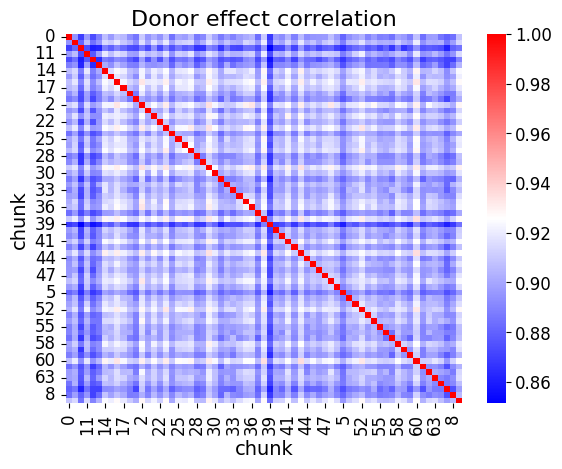

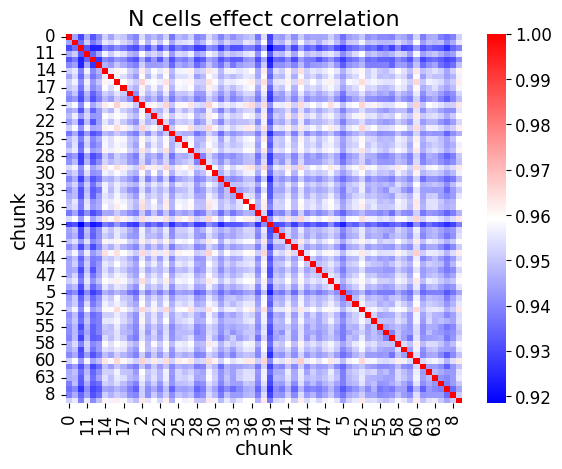

In [33]:
donor_effects = all_de_results[all_de_results.contrast != 'log10_n_cells'].pivot(index=['variable', 'condition'], columns='chunk', values='log_fc').dropna()
sns.heatmap(donor_effects.corr(), cmap='bwr')
plt.title("Donor effect correlation");
plt.show()

count_effects = all_de_results[all_de_results.contrast == 'log10_n_cells'].pivot(index=['variable', 'condition'], columns='chunk', values='log_fc').dropna()
sns.heatmap(count_effects.corr(), cmap='bwr')
plt.title("N cells effect correlation");
plt.show()

## Power on lowly-expressed genes

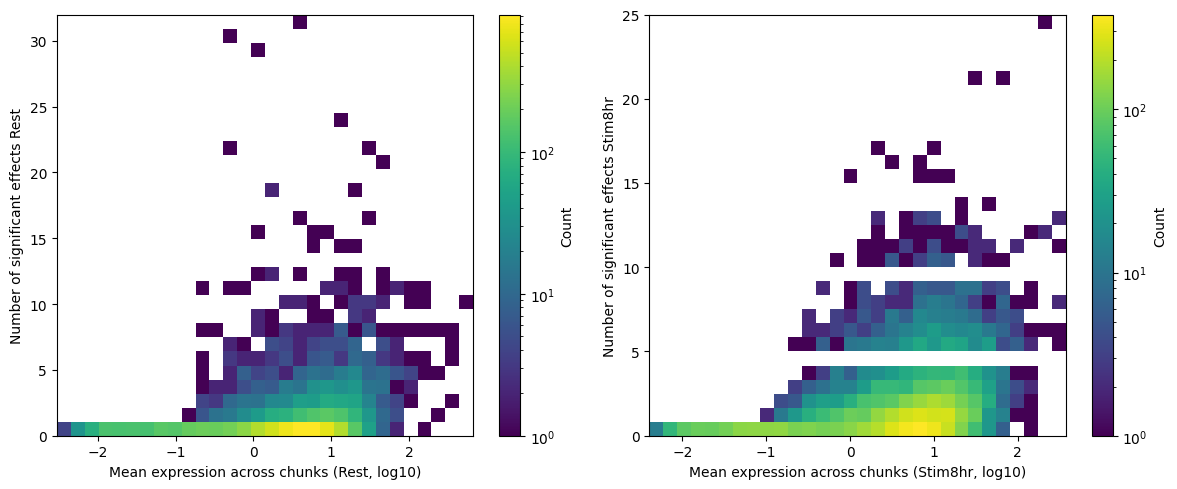

In [12]:
plt.figure(figsize=(12,5))
for i,cond in enumerate(['Rest', 'Stim8hr']):
    plt.subplot(1,2,i+1)
    plt.hist2d(
        np.log10(adata_de.var[f'mean_baseMean_{cond}']), 
        adata_de.var[f'n_signif_effects_{cond}'],
        bins=30, 
        norm=matplotlib.colors.LogNorm()
    )
    plt.colorbar(label='Count')
    # plt.xscale('log')
    plt.xlabel(f'Mean expression across chunks ({cond}, log10)')
    plt.ylabel(f'Number of significant effects {cond}')
plt.tight_layout()


Text(0, 0.5, 'Mean baseMean Rest')

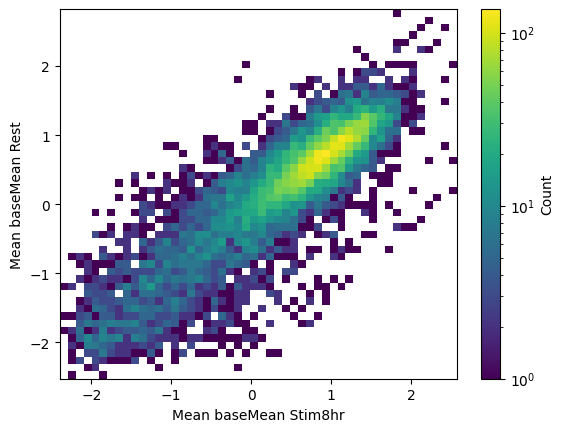

In [13]:
plt.hist2d(
    np.log10(adata_de.var['mean_baseMean_Stim8hr']), 
    np.log10(adata_de.var['mean_baseMean_Rest']), 
    bins=50, 
    norm=matplotlib.colors.LogNorm()
)
plt.colorbar(label='Count')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Mean baseMean Stim8hr')
plt.ylabel('Mean baseMean Rest')

In [14]:
# Exclude from analysis genes with very low base mean across conditions
gs_mask = (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Rest'] > 0.1) 
sum(~gs_mask)

1082

In [15]:
len(gs_mask)

8833

In [16]:
adata_de = adata_de[:, gs_mask].copy()

In [17]:
adata_de

AnnData object with n_obs × n_vars = 6484 × 7751
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'mt', 'n_signif_effects_Rest', 'n_mash_signif_effects_Rest', 'n_signif_effects_Stim8hr', 'n_mash_signif_effects_Stim8hr', 'mean_baseMean_Rest', 'std_baseMean_Rest', 'mean_baseMean_Stim8hr', 'std_baseMean_Stim8hr'
    layers: 'MASH_PosteriorMean', 'MASH_PosteriorSD', 'MASH_lfsr', 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

## On-target effect

In [24]:
adata_de.var_names = adata_de.var['gene_ids'].values

In [25]:
all_targets = adata_de.obs['target_contrast'].astype(str).unique()
measured_targets = adata_de.var_names[adata_de.var_names.isin(all_targets)].tolist()
measured_targets_names = adata_de.var['gene_name'][adata_de.var_names.isin(all_targets)].tolist()

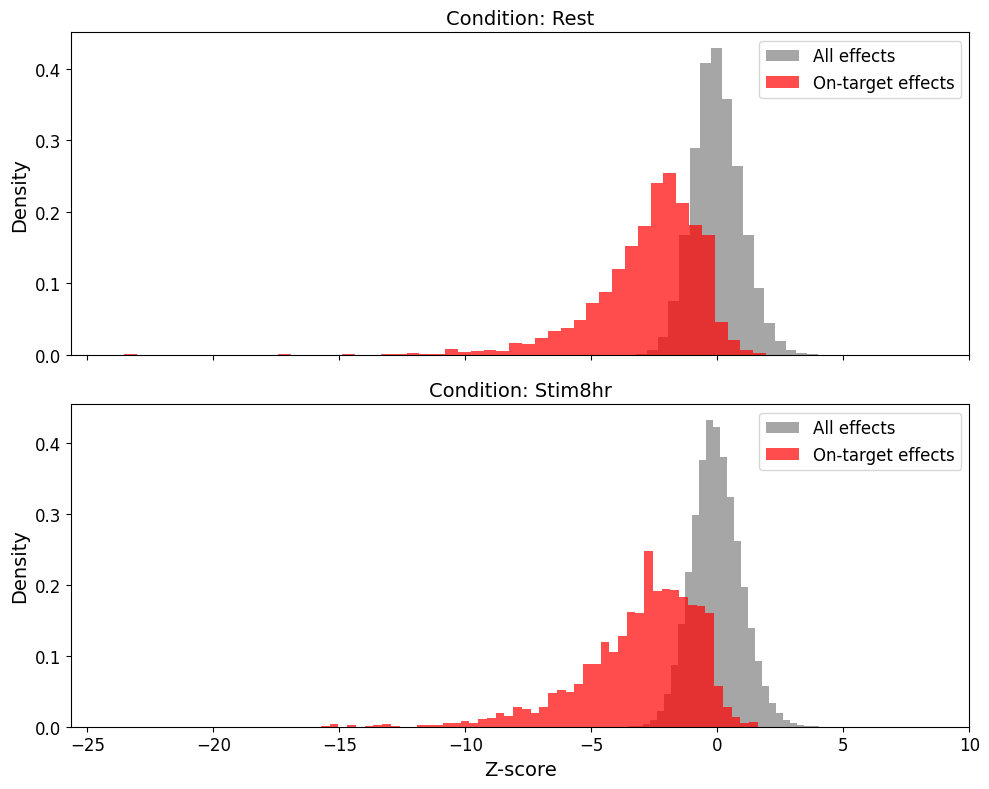

In [26]:
# Get all unique culture conditions
conditions = adata_de.obs['culture_condition'].unique()

# Create a figure with subplots, one for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(10, 4*len(conditions)), sharex=True)

for i, cond in enumerate(conditions):
    # Get on-target effects for this condition
    ontarget_cond = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                  ['target_contrast'] + measured_targets, layer='zscore')
    ontarget_cond = ontarget_cond.set_index('target_contrast').loc[measured_targets]
    
    # Plot histograms with normalized heights (density=True)
    axes[i].hist(adata_de[adata_de.obs['culture_condition'] == cond].layers['zscore'].flatten(), 
                bins=100, density=True, alpha=0.7, color='grey', label='All effects')
    axes[i].hist(np.diag(ontarget_cond.values), bins=50, density=True, alpha=0.7, 
                color='red', label='On-target effects')
    
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(labelsize=12)
    axes[i].legend(fontsize=12)
    axes[i].set_title(f'Condition: {cond}', fontsize=14)
    axes[i].set_xlim(right=10)  # Set upper x-limit to 10

# Set common x-label
plt.xlabel('Z-score', fontsize=14)
plt.tight_layout()


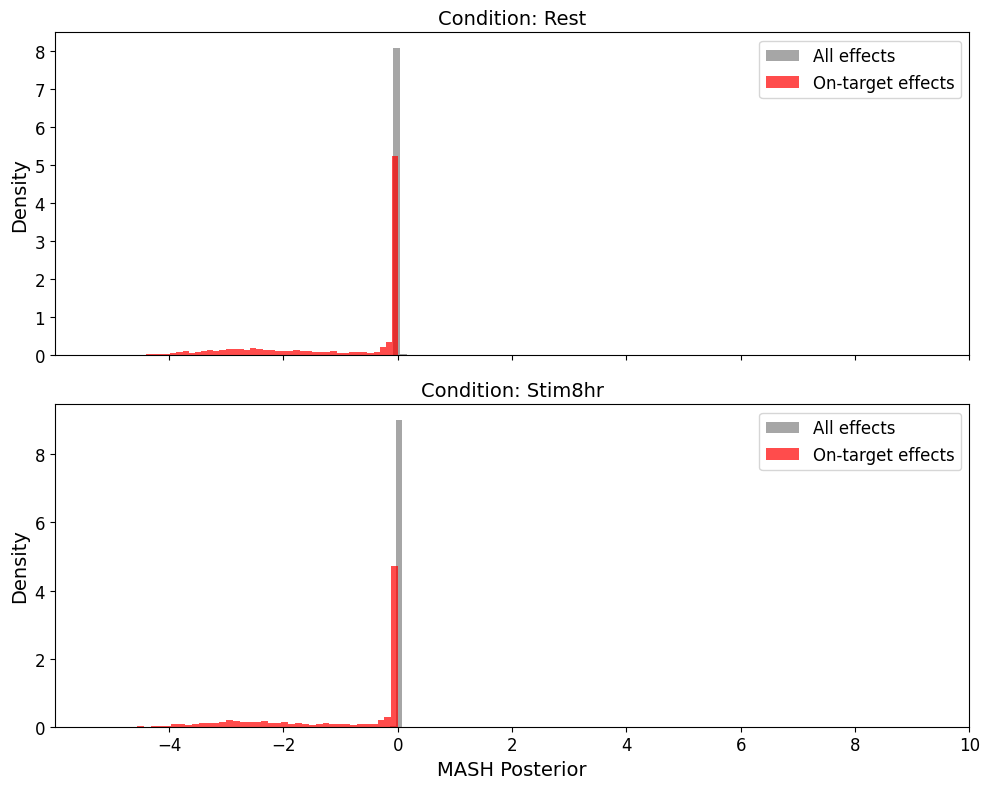

In [27]:
# Get all unique culture conditions
conditions = adata_de.obs['culture_condition'].unique()

# Create a figure with subplots, one for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(10, 4*len(conditions)), sharex=True)

for i, cond in enumerate(conditions):
    # Get on-target effects for this condition
    ontarget_cond = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                  ['target_contrast'] + measured_targets, layer='MASH_PosteriorMean')
    ontarget_cond = ontarget_cond.set_index('target_contrast').loc[measured_targets]
    
    # Plot histograms with normalized heights (density=True)
    axes[i].hist(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_PosteriorMean'].flatten(), 
                bins=100, density=True, alpha=0.7, color='grey', label='All effects')
    axes[i].hist(np.diag(ontarget_cond.values), bins=50, density=True, alpha=0.7, 
                color='red', label='On-target effects')
    
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(labelsize=12)
    axes[i].legend(fontsize=12)
    axes[i].set_title(f'Condition: {cond}', fontsize=14)
    axes[i].set_xlim(right=10)  # Set upper x-limit to 10

# Set common x-label
plt.xlabel('MASH Posterior', fontsize=14)
plt.tight_layout()


Compare DESeq2 estimates with knock-down efficiency estimated with t-test

In [40]:
kd_effect_ttest = pd.read_csv(datadir + 'knockdown_efficacy_simple.csv', index_col=0)
kd_effect_ttest.head()

perturbed_gene  perturbed_gene_expr  perturbed_gene_mean_ntc  \
0  ENSG00000012223             0.000000                 0.000000   
1  ENSG00000012822             0.003279                 0.095198   
2  ENSG00000026025             2.006651                 2.594920   
3  ENSG00000033867             0.032208                 0.551298   
4  ENSG00000034693             0.032066                 0.147726   

   perturbed_gene_std_ntc  n_ntc_cells  perturbed_gene_expr_std  \
0                0.000000      39459.0                 0.000000   
1                0.286363      39459.0                 0.042971   
2                1.064016      39459.0                 1.201968   
3                0.551828      39459.0                 0.159126   
4                0.308244      39459.0                 0.147905   

   n_perturbed_cells  t_statistic        p_value    adj_p_value  \
0                449          NaN            NaN            NaN   
1                516   -38.648063  3.005459e-217  1.397538e-216   
2                914   -14.663909   5.031469e-44   7.311354e-44   
3                377   -59.986581  1.167694e-221  5.715556e-221   
4                360   -14.551766   1.373093e-38   1.934812e-38   

   signif_knockdown  
0             False  
1              True  
2              True  
3              True  
4              True

In [28]:
adata_de.var_names = adata_de.var['gene_ids'].values

In [180]:
ontarget_df = get_ontarget_effect(adata_de)

In [181]:
ontarget_df.significant.sum()/ontarget_df.shape[0]

0.28795698924731183

Text(0.5, 1.0, 'On-target effects')

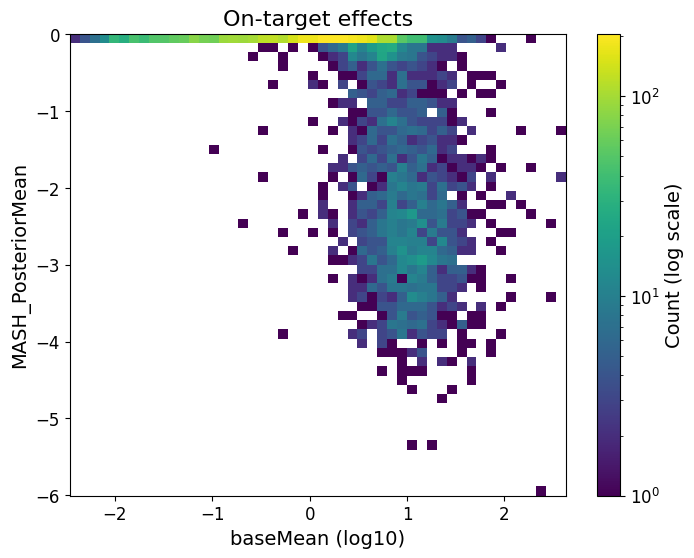

In [52]:
# Create a 2D histogram with logarithmic color scale
plt.figure(figsize=(8, 6))
h = plt.hist2d(
    np.log10(ontarget_df['baseMean']), 
    ontarget_df['MASH_PosteriorMean'],
    bins=50, 
    norm=matplotlib.colors.LogNorm(),
    cmap='viridis'
)
plt.colorbar(label='Count (log scale)')
# plt.xscale('log')
plt.xlabel('baseMean (log10)')
plt.ylabel('MASH_PosteriorMean')
plt.title('On-target effects')

<Axes: xlabel='signif_knockdown', ylabel='MASH_PosteriorMean'>

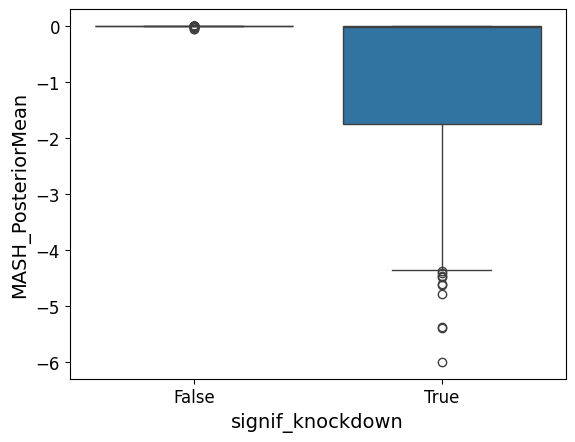

In [53]:
pl_df = pd.merge(
    ontarget_df.rename({'target_contrast':'perturbed_gene'}, axis=1)[['perturbed_gene', 'MASH_PosteriorMean', 'significant']],
    kd_effect_ttest[['perturbed_gene', 't_statistic', 'signif_knockdown']]
).drop('perturbed_gene', axis=1)
sns.boxplot(data=pl_df, y='MASH_PosteriorMean', x='signif_knockdown')

<Axes: xlabel='zscore', ylabel='min_effect_size'>

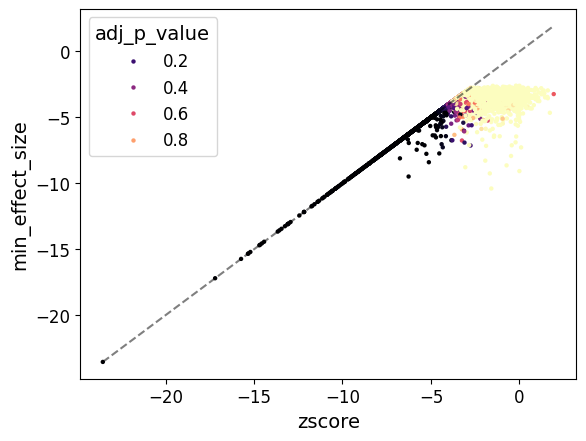

In [55]:
min_effect_gene = adata_de.var.iloc[np.argmin(adata_de.layers['zscore'], axis=1)]['gene_name']
min_effect_size = np.min(adata_de.layers['zscore'], axis=1)
min_effect_df = pd.DataFrame(np.column_stack([adata_de.obs['culture_condition'].values, adata_de.obs['target_contrast'].values, min_effect_gene.values, min_effect_size]), 
             columns=['culture_condition','target_contrast','min_effect_gene', 'min_effect_size'])

pl_df = pd.merge(ontarget_df, min_effect_df)

# Add diagonal line first so it appears under the points
x_min = pl_df['zscore'].min()
x_max = pl_df['zscore'].max()
plt.plot([x_min, x_max], [x_min, x_max], 'k--', alpha=0.5)

# Plot the scatter with magma color scale
sns.scatterplot(data=pl_df, x='zscore', y='min_effect_size', 
                hue='adj_p_value', s=10, linewidth=0, palette='magma')

Text(0, 0.5, 'Smallest effect size\n(MASH posterior mean)')

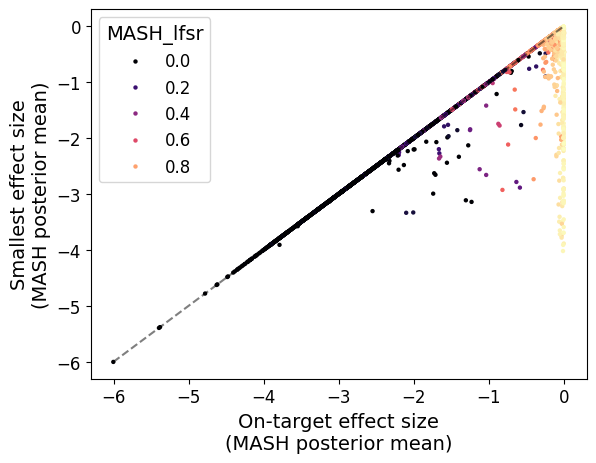

In [56]:
min_effect_gene = adata_de.var.iloc[np.argmin(adata_de.layers['MASH_PosteriorMean'], axis=1)]['gene_name']
min_effect_size = np.min(adata_de.layers['MASH_PosteriorMean'], axis=1)
min_effect_df = pd.DataFrame(np.column_stack([adata_de.obs['culture_condition'].values, adata_de.obs['target_contrast'].values, min_effect_gene.values, min_effect_size]), 
             columns=['culture_condition','target_contrast','min_effect_gene', 'min_effect_size'])

pl_df = pd.merge(ontarget_df, min_effect_df)

# Add diagonal line first so it appears under the points
x_min = pl_df['MASH_PosteriorMean'].min()
x_max = pl_df['MASH_PosteriorMean'].max()
plt.plot([x_min, x_max], [x_min, x_max], 'k--', alpha=0.5)

# Plot the scatter with magma color scale
sns.scatterplot(data=pl_df, x='MASH_PosteriorMean', y='min_effect_size', 
                hue='MASH_lfsr', s=10, linewidth=0, palette='magma');
plt.xlabel('On-target effect size\n(MASH posterior mean)');
plt.ylabel('Smallest effect size\n(MASH posterior mean)')

### Evidence for off-target in close genes

In [161]:
# Read gene annotations
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()
genes_coords = genes.set_index('gene_id').loc[adata_de.var['gene_ids']][['seq_name', 'gene_seq_start', 'gene_seq_end', 'seq_strand']]

In [182]:
import bioframe as bf
import pandas as pd
import numpy as np

def find_closest_genes_by_tss(target_ids, gene_coordinates, k=3):
    """
    Find the k closest genes for each target gene ID based on 
    transcription start site (TSS) distance.
    
    Parameters:
    -----------
    target_ids : list
        List of Ensembl IDs for target genes
    gene_coordinates : pandas.DataFrame
        DataFrame containing gene coordinates with Ensembl IDs as index
    k : int
        Number of closest genes to find (default: 3)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with target genes and their k closest genes
    """
    # Convert genes_coords to bioframe-compatible format with TSS
    genes_df = gene_coordinates.reset_index().copy()
    
    # Calculate TSS for each gene (accounting for strand if available)
    if 'seq_strand' in genes_df.columns:
        # If strand information is available, use it to determine TSS
        genes_df['tss'] = genes_df.apply(
            lambda x: x['gene_seq_start'] if x['seq_strand'] == 1 else x['gene_seq_end'], 
            axis=1
        )
    else:
        # If no strand info, assume all genes are on + strand
        genes_df['tss'] = genes_df['gene_seq_start']
    
    # Create bioframe-compatible dataframe with TSS as both start and end
    # This represents the TSS as a single point
    tss_df = genes_df.rename(
        columns={'gene_id': 'name', 'seq_name': 'chrom'}
    )
    tss_df['start'] = tss_df['tss']
    tss_df['end'] = tss_df['tss'] + 1  # Add 1 to make a 1bp interval
    
    # Create a subset for targets
    targets_tss_df = tss_df[tss_df['name'].isin(target_ids)].copy()
    
    if targets_tss_df.empty:
        raise ValueError("None of the target IDs were found in the gene coordinates dataframe")
    
    # Create a dictionary to store results
    results = []
    
    # Find closest genes for each target
    for _, target in targets_tss_df.iterrows():
        # Create a single-row DataFrame for the current target
        target_region = pd.DataFrame([{
            'chrom': target['chrom'],
            'start': target['start'],
            'end': target['end'],
            'name': target['name']
        }])
        
        # Remove the current target from the genes dataframe to avoid self-matches
        other_genes_tss = tss_df[tss_df['name'] != target['name']].copy()
        other_genes_tss = other_genes_tss[['chrom', 'start', 'end', 'name']]
        
        # Find k closest genes based on TSS with explicit suffixes
        closest = bf.closest(
            target_region,
            other_genes_tss,
            k=k,
            ignore_overlaps=False,
            suffixes=('_target', '_closest')  # Explicitly define suffixes
        )
        
        # Extract relevant information using the new suffix names
        for i in range(min(k, len(closest))):
            closest_gene = closest.iloc[i]
            results.append({
                'target_id': target['name'],
                'target_chrom': target['chrom'],
                'target_tss': target['tss'],
                'rank': i + 1,
                'closest_id': closest_gene['name_closest'],
                'closest_chrom': closest_gene['chrom_closest'],
                'closest_tss': closest_gene['start_closest'],
                'distance': closest_gene['distance']
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Usage:
closest_genes_by_tss = find_closest_genes_by_tss(measured_targets, genes_coords)

In [183]:
closest_id = closest_genes_by_tss.pivot(index='target_id', columns='rank', values='closest_id')
closest_dist = closest_genes_by_tss.pivot(index='target_id', columns='rank', values='distance')

closest_genes_by_tss = closest_genes_by_tss.rename({'closest_id':'gene_ids'}, axis=1)

In [184]:
all_closest_genes_effect = pd.DataFrame()

from tqdm.notebook import tqdm
for t in tqdm(measured_targets, desc="Processing targets"):
    # Get DE results for closest genes to this target
    closest_genes_effect = get_DE_results_long(
        adata_de,
        targets=[t], genes=closest_id.loc[t], 
        effect_estimates = ['zscore', 'MASH_PosteriorMean'],
        target_id_col = 'target_contrast',
        gene_id_col='gene_ids'
    )
    
    # Get distance information for this target
    dist_df = closest_genes_by_tss[closest_genes_by_tss.target_id == t][['gene_ids', 'rank', 'distance']]
    
    # Merge distance information with DE results
    closest_genes_effect = pd.merge(closest_genes_effect, dist_df)
    
    # Concatenate to main results dataframe
    all_closest_genes_effect = pd.concat([all_closest_genes_effect, closest_genes_effect])

# Add on-target effects
all_ontarget_effect = ontarget_df[ontarget_df.target_contrast.isin(measured_targets)].copy()
all_ontarget_effect['distance'] = 0
all_ontarget_effect['rank'] = 0
all_ontarget_effect = pd.concat([all_ontarget_effect, all_closest_genes_effect]).sort_values(['target_contrast', 'rank'])

Processing targets:   0%|          | 0/2325 [00:00<?, ?it/s]

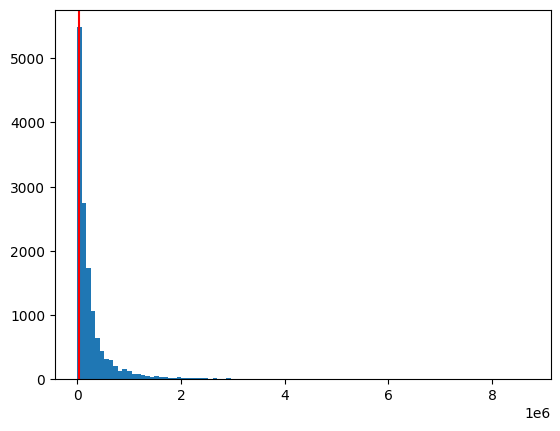

In [186]:
plt.hist(all_ontarget_effect[all_ontarget_effect['rank'] > 0].distance, bins=100);
plt.axvline(30000, color='red')
all_ontarget_effect_close = all_ontarget_effect[all_ontarget_effect.distance < 30000]

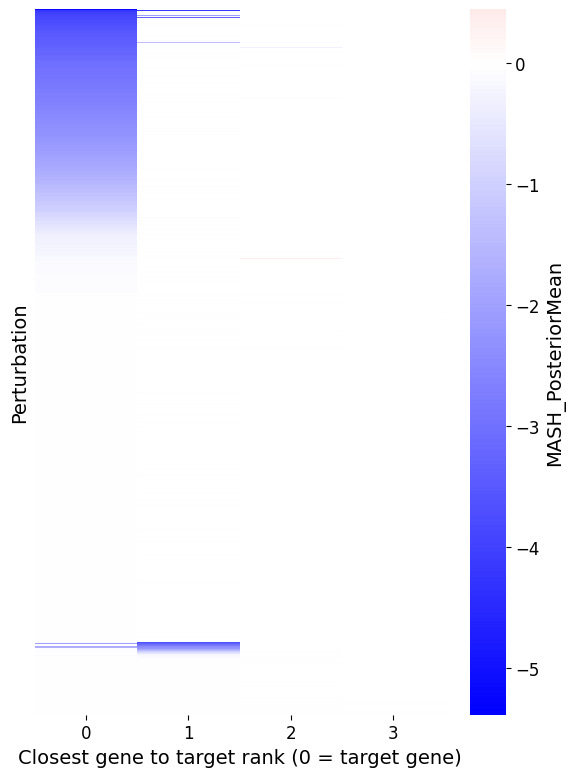

In [63]:
# Pivot the data to create a matrix suitable for heatmap
heatmap_data = all_ontarget_effect_close.pivot_table(
    values='MASH_PosteriorMean', 
    index='target_contrast', 
    columns='rank', 
    aggfunc='mean'
)

# First sort by the rank with the minimum effect size, then within each rank group sort by effect size
min_rank_per_target = heatmap_data.idxmin(axis=1)
sorted_targets = []
for rank in sorted(min_rank_per_target.unique()):
    # Get targets with minimum effect at this rank
    targets_with_min_at_rank = min_rank_per_target[min_rank_per_target == rank].index
    # Sort these targets by their effect size at this rank
    sorted_by_effect = heatmap_data.loc[targets_with_min_at_rank, rank].sort_values().index
    sorted_targets.extend(sorted_by_effect)
heatmap_data = heatmap_data.loc[sorted_targets]

plt.figure(figsize=(6, 8))
ax = sns.heatmap(heatmap_data, cbar_kws={'label': 'MASH_PosteriorMean'}, center=0, cmap='bwr')
# plt.title('Effect size (MASH_PosteriorMean) by distance rank from target gene')
plt.xlabel('Closest gene to target rank (0 = target gene)')
plt.ylabel('Perturbation')
# Hide y-axis labels as requested
ax.set_yticks([])
plt.tight_layout()

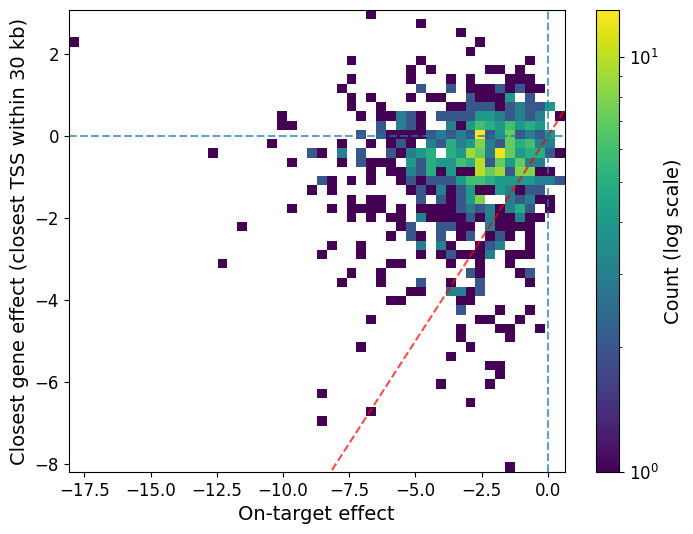

In [273]:
# Pivot the data to create a matrix suitable for heatmap
heatmap_data = all_ontarget_effect_close.pivot_table(
    values='zscore', 
    index='target_contrast', 
    columns='rank', 
    aggfunc='mean'
).iloc[:, 0:2].dropna()

# Create a 2D histogram with logarithmic color scale
plt.figure(figsize=(8, 6))
h = plt.hist2d(heatmap_data[0], heatmap_data[1], bins=50, 
               norm=matplotlib.colors.LogNorm(), cmap='viridis')
plt.colorbar(h[3], label='Count (log scale)')
plt.xlabel('On-target effect')
plt.ylabel('Closest gene effect (closest TSS within 30 kb)')

# Add diagonal line
min_val = min(heatmap_data[0].min(), heatmap_data[1].min())
max_val = max(heatmap_data[0].max(), heatmap_data[1].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='y=x')
# plt.legend()
plt.axhline(0, linestyle='--', alpha=0.7)
plt.axvline(0, linestyle='--', alpha=0.7)

In [64]:
min_rank_per_target.index[(min_rank_per_target==1) & (heatmap_data[1] < -0.1)]

Index(['ENSG00000037749', 'ENSG00000049167', 'ENSG00000053770',
       'ENSG00000067829', 'ENSG00000075303', 'ENSG00000081692',
       'ENSG00000088727', 'ENSG00000092020', 'ENSG00000100294',
       'ENSG00000100938', 'ENSG00000102893', 'ENSG00000108187',
       'ENSG00000112304', 'ENSG00000113108', 'ENSG00000116791',
       'ENSG00000122335', 'ENSG00000122512', 'ENSG00000122687',
       'ENSG00000123427', 'ENSG00000123600', 'ENSG00000128311',
       'ENSG00000128590', 'ENSG00000130347', 'ENSG00000130921',
       'ENSG00000132286', 'ENSG00000134897', 'ENSG00000135736',
       'ENSG00000135740', 'ENSG00000139517', 'ENSG00000140025',
       'ENSG00000143569', 'ENSG00000144357', 'ENSG00000145348',
       'ENSG00000151500', 'ENSG00000162144', 'ENSG00000163536',
       'ENSG00000163913', 'ENSG00000168826', 'ENSG00000169972',
       'ENSG00000169989', 'ENSG00000175575', 'ENSG00000178700',
       'ENSG00000180185', 'ENSG00000180979', 'ENSG00000185522',
       'ENSG00000185885', 'ENSG000001876

/tmp/ipykernel_3528334/3330957835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_ontarget_effect_close['putative_offtarget'] = all_ontarget_effect_close.target_contrast.isin(min_rank_per_target.index[(min_rank_per_target==1) & (heatmap_data[1] < -0.1)])
/tmp/ipykernel_3528334/3330957835.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=all_ontarget_effect_close, x='rank', y='zscore', scale='width', cut=0, hue='putative_offtarget')


<Axes: xlabel='rank', ylabel='zscore'>

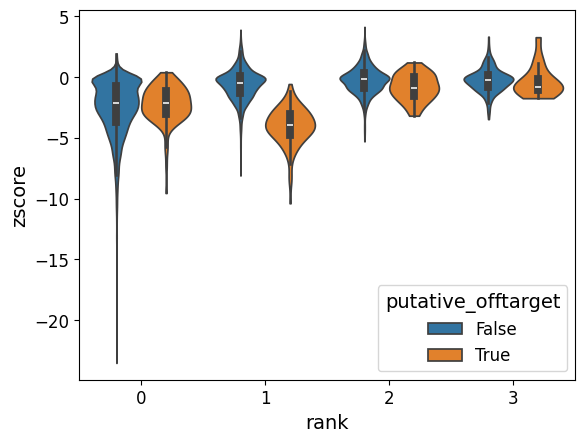

In [65]:
all_ontarget_effect_close['putative_offtarget'] = all_ontarget_effect_close.target_contrast.isin(min_rank_per_target.index[(min_rank_per_target==1) & (heatmap_data[1] < -0.1)])
sns.violinplot(data=all_ontarget_effect_close, x='rank', y='zscore', scale='width', cut=0, hue='putative_offtarget')

/tmp/ipykernel_3528334/2128708139.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=pl_df, x='putative_offtarget', y='distance', hue='putative_offtarget', cut=0, scale='width');


Text(0, 0.5, 'TSS distance to\nclosest gene (bp)')

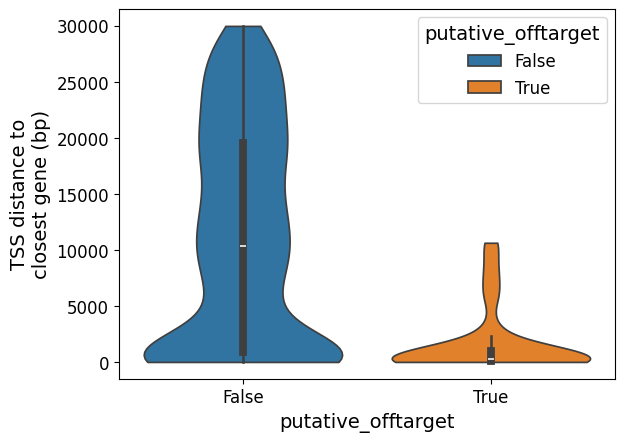

In [66]:
pl_df = all_ontarget_effect_close.copy()
pl_df['distance'] = np.where(pl_df.distance == 0, 0.1, pl_df.distance)
pl_df = pl_df[pl_df['rank'] == 1]
sns.violinplot(data=pl_df, x='putative_offtarget', y='distance', hue='putative_offtarget', cut=0, scale='width');
plt.ylabel('TSS distance to\nclosest gene (bp)')

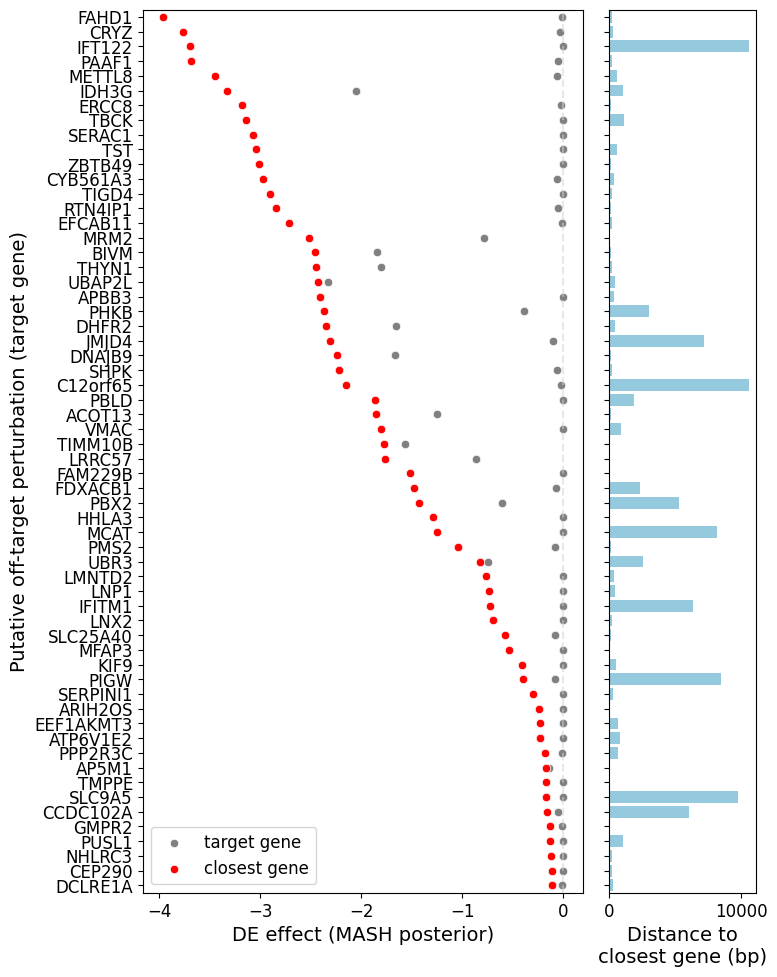

In [69]:
dist_rank1 = all_ontarget_effect_close[all_ontarget_effect_close['putative_offtarget'] & (all_ontarget_effect_close['rank'] == 1)].set_index('target_contrast')['distance']

pl_df = heatmap_data.loc[dist_rank1.index].copy()
# pl_df['distance_rank1'] = 
pl_df['distance_rank1'] = dist_rank1
pl_df = pl_df.reset_index()
pl_df = pl_df.sort_values(1)
pl_df = pd.merge(pl_df, adata_de.obs[['target_contrast', 'target_contrast_gene_name']].drop_duplicates(), how='left')
pl_df['target_contrast_gene_name'] = pl_df['target_contrast_gene_name'].astype(str)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,10), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

# First subplot with scatterplots
sns.scatterplot(data=pl_df, x=0, y='target_contrast_gene_name', color='grey', ax=ax1, label='target gene')
sns.scatterplot(data=pl_df, x=1, y='target_contrast_gene_name', color='red', ax=ax1, label='closest gene')
ax1.legend()
ax1.axvline(0, color='lightgray', linestyle='--', alpha=0.5)
ax1.set_xlabel('DE effect (MASH posterior)')
ax1.set_ylabel('Putative off-target perturbation (target gene)')

# Second subplot with barplot showing distances
sns.barplot(data=pl_df, x='distance_rank1', y='target_contrast_gene_name', ax=ax2, orient='h', color='skyblue')
ax2.set_xlabel('Distance to\nclosest gene (bp)')
ax2.set_ylabel('')
plt.tight_layout()


In [70]:
putative_offtargets = all_ontarget_effect_close[all_ontarget_effect_close['putative_offtarget']]['target_contrast'].unique()
# Create a dictionary mapping target_id to gene_id for putative offtargets
offtarget_dict = dict(zip(
    closest_genes_by_tss[closest_genes_by_tss['target_id'].isin(putative_offtargets) & (closest_genes_by_tss['rank'] == 1)]['target_id'],
    closest_genes_by_tss[closest_genes_by_tss['target_id'].isin(putative_offtargets) & (closest_genes_by_tss['rank'] == 1)]['gene_ids']
))
offtarget_genes = closest_genes_by_tss[closest_genes_by_tss['target_id'].isin(putative_offtargets) & (closest_genes_by_tss['rank'] == 1)]['gene_ids'].unique()

In [71]:
pairs = [(k,v) for k,v in offtarget_dict.items() if v in measured_targets]
len(pairs)


16

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


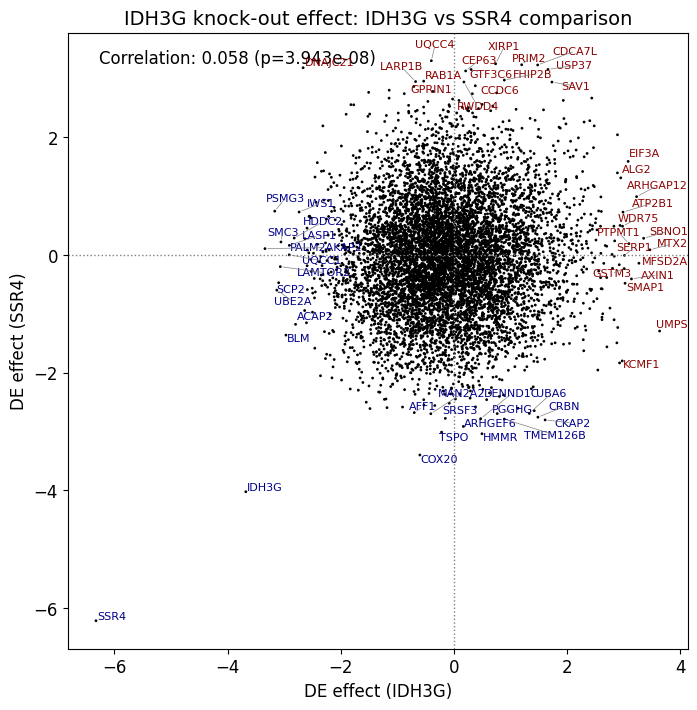

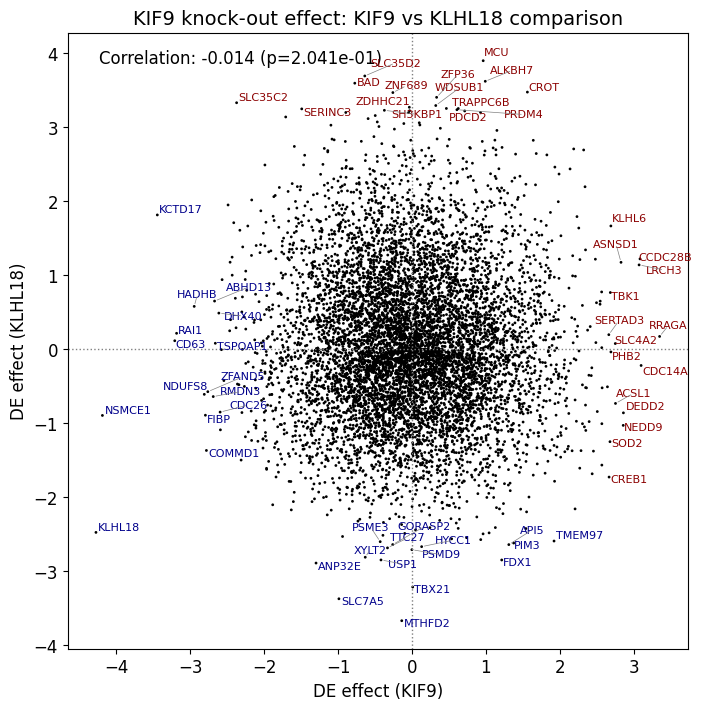

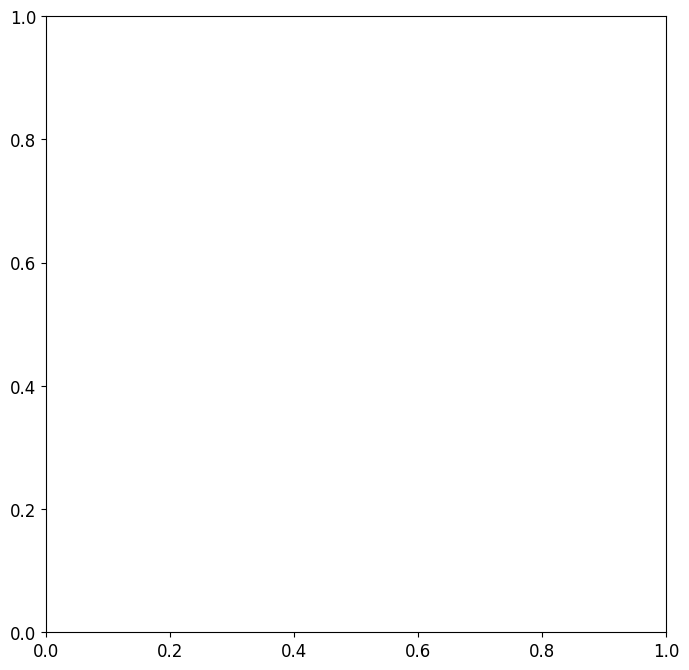

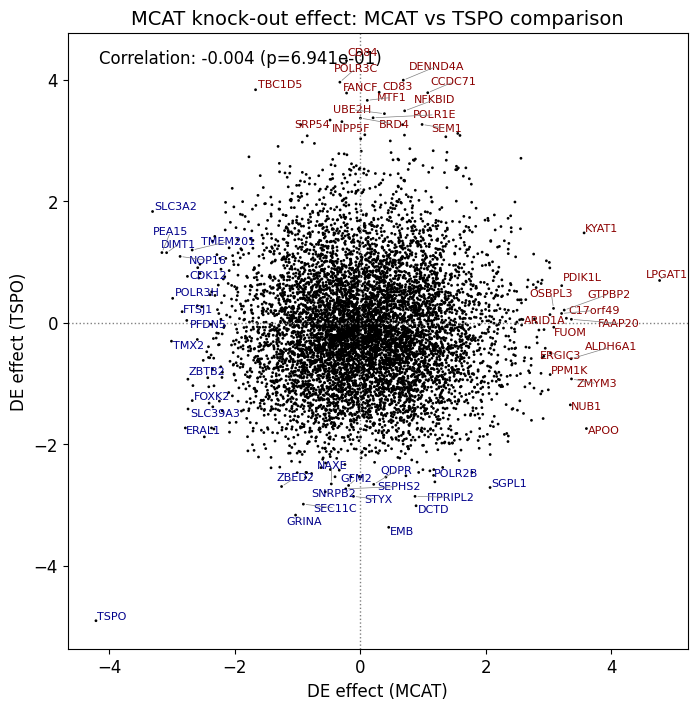

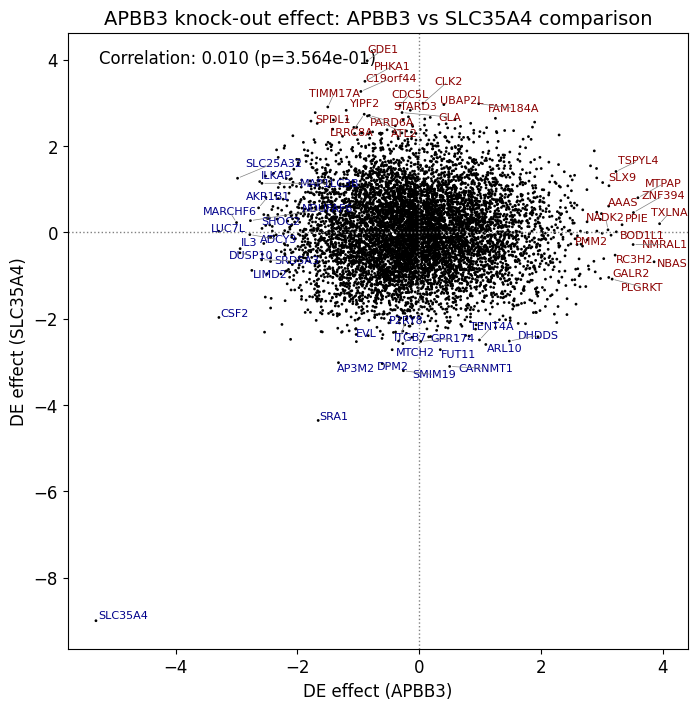

In [72]:
for i,j in pairs[0:5]:
    try:
        adata_de.var_names = adata_de.var['gene_name'].values
        t_name_1 = adata_de.var_names[adata_de.var['gene_ids'] == i][0]
        t_name_2 = adata_de.var_names[adata_de.var['gene_ids'] == j][0]
        # t_name='IDH3G'

        res = plot_effect_comparison(
            adata_de, 
            comparison_params = {
                'target_contrast_gene_name':[ t_name_1, t_name_2],
                'culture_condition':['Stim8hr'],
                'stat':['zscore']
            }
            )
    except:
        continue

Compare effects on all closest genes within a range

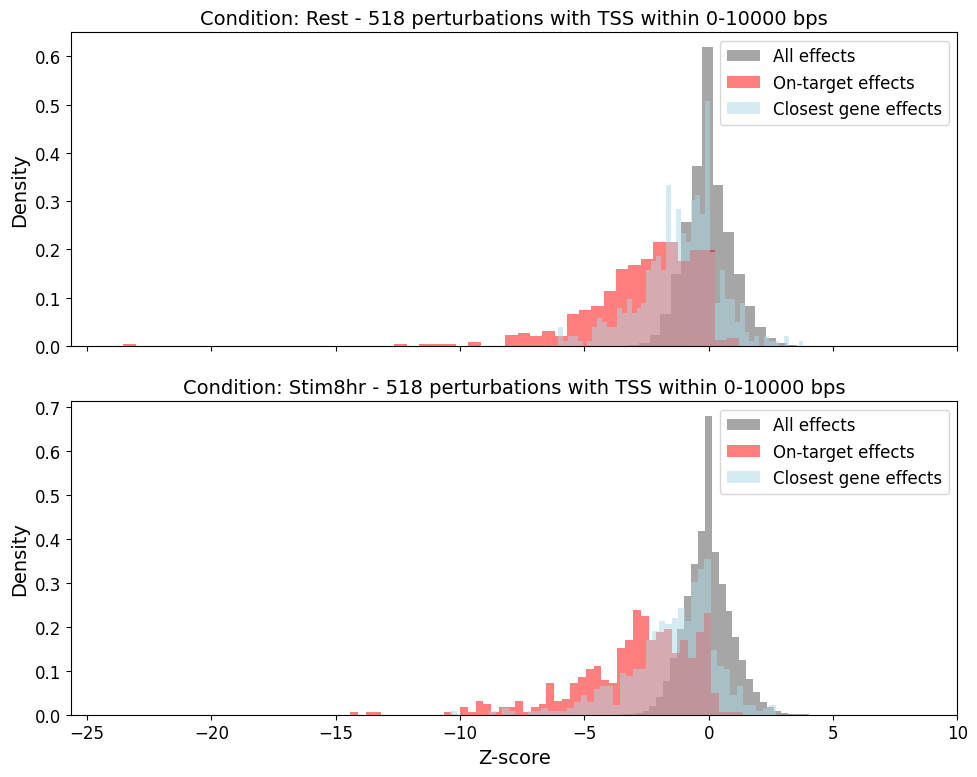

In [75]:
# Get all unique culture conditions
conditions = adata_de.obs['culture_condition'].unique()

min_dist = 0
max_dist = 10000
# Keep targets where the closest gene is between 10kb and 30kb away
keep_targets = all_ontarget_effect[all_ontarget_effect['rank'] == 1][
    (all_ontarget_effect[all_ontarget_effect['rank'] == 1].distance >= min_dist) & 
    (all_ontarget_effect[all_ontarget_effect['rank'] == 1].distance < max_dist)
].target_contrast.unique()
pl_df = all_ontarget_effect[all_ontarget_effect.target_contrast.isin(keep_targets)]
n_perts = pl_df.target_contrast.nunique()
# Create a figure with subplots, one for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(10, 4*len(conditions)), sharex=True)

for i, cond in enumerate(conditions):
    axes[i].hist(adata_de[adata_de.obs['culture_condition'] == cond].layers['zscore'].flatten(), 
                bins=100, density=True, alpha=0.7, color='grey', label='All effects')
    # axes[i].hist(all_ontarget_effect[(all_ontarget_effect['rank'] == 0) & (all_ontarget_effect.culture_condition==cond)]['zscore'], bins=50, density=True, alpha=0.7, 
    #             color='red', label='On-target effects')
    axes[i].hist(pl_df[(pl_df['rank'] == 0) & (pl_df.culture_condition==cond)]['zscore'], bins=50, density=True, alpha=0.5, 
                color='red', label='On-target effects');
    axes[i].hist(pl_df[(pl_df['rank'] == 1) & (pl_df.culture_condition==cond)]['zscore'], bins=50, density=True, alpha=0.5, 
                color='lightblue', label=f'Closest gene effects')
    
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(labelsize=12)
    axes[i].legend(fontsize=12)
    axes[i].set_title(f'Condition: {cond} - {n_perts} perturbations with TSS within {min_dist}-{max_dist} bps', fontsize=14)
    axes[i].set_xlim(right=10)  # Set upper x-limit to 10

# Set common x-label
plt.xlabel('Z-score', fontsize=14)
plt.tight_layout()

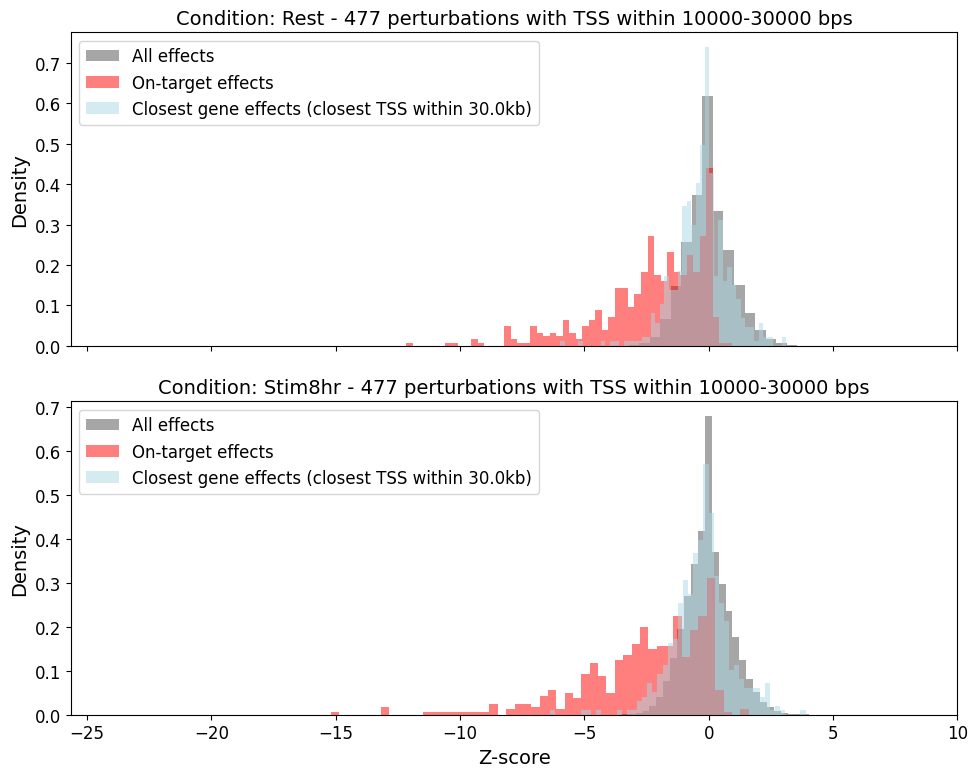

In [79]:
min_dist = 10000
max_dist = 30000
# Keep targets where the closest gene is between 10kb and 30kb away
keep_targets = all_ontarget_effect[all_ontarget_effect['rank'] == 1][
    (all_ontarget_effect[all_ontarget_effect['rank'] == 1].distance >= min_dist) & 
    (all_ontarget_effect[all_ontarget_effect['rank'] == 1].distance < max_dist)
].target_contrast.unique()
pl_df = all_ontarget_effect[all_ontarget_effect.target_contrast.isin(keep_targets)]
n_perts = pl_df.target_contrast.nunique()
# Create a figure with subplots, one for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(10, 4*len(conditions)), sharex=True)

for i, cond in enumerate(conditions):
    axes[i].hist(adata_de[adata_de.obs['culture_condition'] == cond].layers['zscore'].flatten(), 
                bins=100, density=True, alpha=0.7, color='grey', label='All effects')
    # axes[i].hist(all_ontarget_effect[(all_ontarget_effect['rank'] == 0) & (all_ontarget_effect.culture_condition==cond)]['zscore'], bins=50, density=True, alpha=0.7, 
    #             color='red', label='On-target effects')
    axes[i].hist(pl_df[(pl_df['rank'] == 0) & (pl_df.culture_condition==cond)]['zscore'], bins=50, density=True, alpha=0.5, 
                color='red', label='On-target effects');
    axes[i].hist(pl_df[(pl_df['rank'] == 1) & (pl_df.culture_condition==cond)]['zscore'], bins=50, density=True, alpha=0.5, 
                color='lightblue', label=f'Closest gene effects (closest TSS within {max_dist/1000}kb)')
    
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(labelsize=12)
    axes[i].legend(fontsize=12)
    axes[i].set_title(f'Condition: {cond} - {n_perts} perturbations with TSS within {min_dist}-{max_dist} bps', fontsize=14)
    axes[i].set_xlim(right=10)  # Set upper x-limit to 10

# Set common x-label
plt.xlabel('Z-score', fontsize=14)
plt.tight_layout()

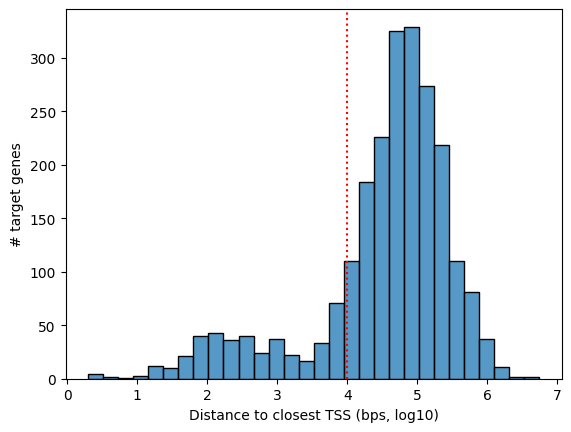

In [187]:
sns.histplot(np.log10(all_ontarget_effect[all_ontarget_effect['rank'] == 1][['target_contrast', 'distance']].drop_duplicates().distance.sort_values()+1), bins=30);
plt.axvline(np.log10(10000), linestyle=':', color='red');
plt.xlabel('Distance to closest TSS (bps, log10)');
plt.ylabel('# target genes');

In [188]:
sum(all_ontarget_effect[all_ontarget_effect['rank'] == 1][['target_contrast', 'distance']].drop_duplicates().distance < 10000)


441

In [189]:
sum(all_ontarget_effect[all_ontarget_effect['rank'] == 1].distance < 10000)

882

In [190]:
all_ontarget_effect

index             gene  MASH_PosteriorMean    log_fc  \
0        ENSG00000000419_Rest  ENSG00000000419           -0.568185 -0.495822   
2325  ENSG00000000419_Stim8hr  ENSG00000000419           -1.186462 -1.635656   
1        ENSG00000000419_Rest  ENSG00000124217           -0.011514       NaN   
4     ENSG00000000419_Stim8hr  ENSG00000124217           -0.011618       NaN   
0        ENSG00000000419_Rest  ENSG00000101126           -0.002385       NaN   
...                       ...              ...                 ...       ...   
4     ENSG00000278540_Stim8hr  ENSG00000276234            0.000424       NaN   
0        ENSG00000278540_Rest  ENSG00000276023           -0.003151       NaN   
3     ENSG00000278540_Stim8hr  ENSG00000276023           -0.004203       NaN   
2        ENSG00000278540_Rest  ENSG00000278053           -0.000227       NaN   
5     ENSG00000278540_Stim8hr  ENSG00000278053           -0.000273       NaN   

        zscore   baseMean  adj_p_value  MASH_lfsr  significant gene_name  \
0    -1.925512  12.960963     0.998866   0.126216        False      DPM1   
2325 -6.336320  25.309086     0.000002   0.000101         True      DPM1   
1    -1.911701        NaN     0.998866        NaN        False       NaN   
4    -2.388766        NaN     0.999866        NaN        False       NaN   
0    -0.233068        NaN     0.998866        NaN        False       NaN   
...        ...        ...          ...        ...          ...       ...   
4     0.860963        NaN     0.999620        NaN        False       NaN   
0     0.496871        NaN     0.999988        NaN        False       NaN   
3    -2.516287        NaN     0.999620        NaN        False       NaN   
2     0.287334        NaN     0.999988        NaN        False       NaN   
5    -0.374683        NaN     0.999620        NaN        False       NaN   

     culture_condition  target_contrast  distance  rank         gene_ids  \
0                 Rest  ENSG00000000419         0     0              NaN   
2325           Stim8hr  ENSG00000000419         0     0              NaN   
1                 Rest  ENSG00000000419       321     1  ENSG00000124217   
4              Stim8hr  ENSG00000000419       321     1  ENSG00000124217   
0                 Rest  ENSG00000000419     27702     2  ENSG00000101126   
...                ...              ...       ...   ...              ...   
4              Stim8hr  ENSG00000278540        49     1  ENSG00000276234   
0                 Rest  ENSG00000278540     83054     2  ENSG00000276023   
3              Stim8hr  ENSG00000278540     83054     2  ENSG00000276023   
2                 Rest  ENSG00000278540    236609     3  ENSG00000278053   
5              Stim8hr  ENSG00000278540    236609     3  ENSG00000278053   

     target_contrast_gene_name  
0                          NaN  
2325                       NaN  
1                         DPM1  
4                         DPM1  
0                         DPM1  
...                        ...  
4                        ACACA  
0                        ACACA  
3                        ACACA  
2                        ACACA  
5                        ACACA  

[18600 rows x 16 columns]

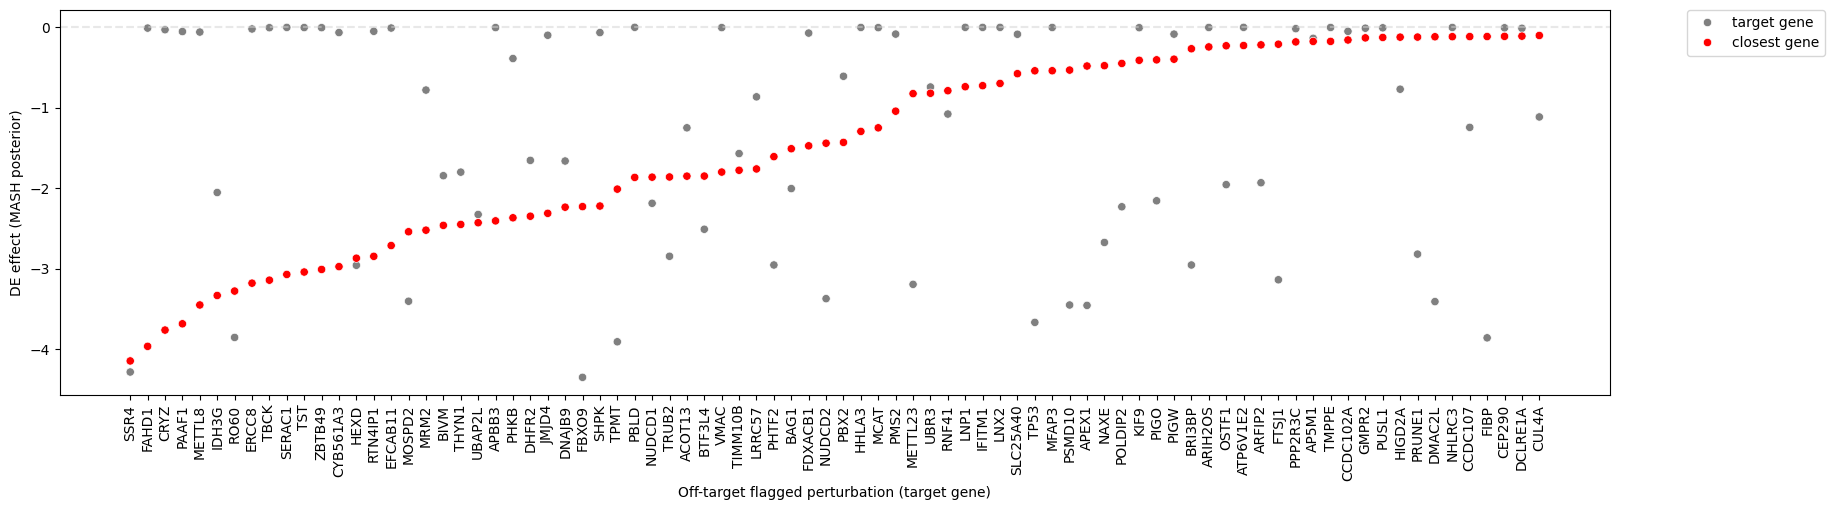

In [273]:
dist_thresh = 10000
keep_targets = all_ontarget_effect[all_ontarget_effect['rank'] == 1][all_ontarget_effect[all_ontarget_effect['rank'] == 1].distance < dist_thresh].target_contrast.unique()
pl_df = all_ontarget_effect[all_ontarget_effect.target_contrast.isin(keep_targets)]
heatmap_data = pl_df.pivot_table(
    values='MASH_PosteriorMean', 
    index='target_contrast', 
    columns='rank', 
    aggfunc='mean'
)

# heatmap_data
suspects = pl_df[pl_df.target_contrast.isin(heatmap_data[heatmap_data[1] < -0.1].index)].gene_name.dropna().unique().tolist()
pl_df = heatmap_data[heatmap_data[1] < -0.1].iloc[:, 0:2]
pl_df.index = suspects
order_targets = pl_df.sort_values(1).index
pl_df = pl_df.reset_index().melt(id_vars='index')
pl_df['index'] = pl_df['index'].astype('category').cat.reorder_categories(order_targets)
# Rename rank values for the legend
rank_labels = {0: 'target gene', 1: 'closest gene'}
pl_df['rank'] = pl_df['rank'].map(rank_labels)

plt.figure(figsize=(20,5))
sns.scatterplot(data=pl_df, x='index', y='value', hue='rank', palette=['grey', 'red'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.axhline(0, color='lightgray', linestyle='--', alpha=0.5)
plt.ylabel('DE effect (MASH posterior)')
plt.xlabel('Off-target flagged perturbation (target gene)')
plt.xticks(rotation=90);  # Rotate x-axis labels for better readability


In [194]:
len(suspects)/all_ontarget_effect.target_contrast.nunique()

0.03526881720430108

## Power and number of cells

In [22]:
de_counts = get_de_stats(adata_de, signif_col='MASH_lfsr', alpha=0.1)

In [23]:

# Add info on on-target effect
effect_col = 'MASH_PosteriorMean'
if ontarget_df is not None:
    de_counts = pd.merge(
        de_counts,
        ontarget_df.rename({effect_col:'ontarget_effect_size', 'significant':'ontarget_significant', 'culture_condition':'condition'}, axis=1)[
        ['ontarget_effect_size', 'ontarget_significant', 'target_contrast', 'condition', 'baseMean']
        ]
    )

de_counts['offtarget_flag'] = de_counts.target_name.isin(suspects)

de_counts.head()

NameError: name 'ontarget_df' is not defined

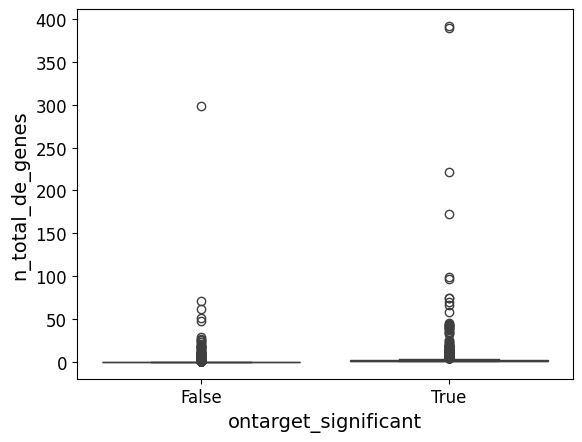

In [239]:
# Add a small constant to n_total_de_genes to handle zeros
de_counts_plot = de_counts.copy()
# de_counts_plot['n_total_de_genes_adj'] = de_counts_plot['n_total_de_genes']  # Add 1 to handle zeros

scatter = sns.boxplot(
    data=de_counts_plot, 
    x='ontarget_significant', 
    # hue='baseMean', 
    y='n_total_de_genes', 
    # s=3, palette='viridis',
    # hue_norm=LogNorm()
);
# plt.yscale('log')

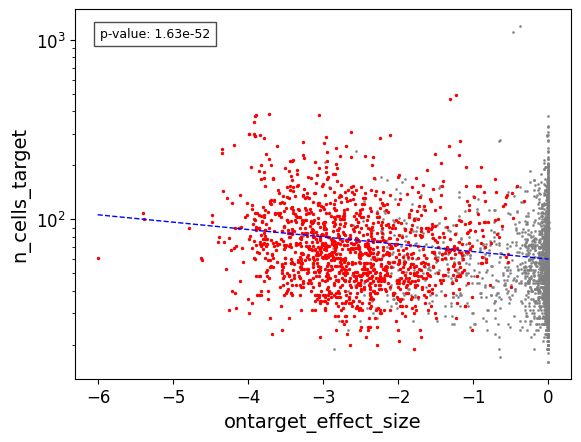

In [240]:
# Create scatter plot for all data points
sns.scatterplot(
    data=de_counts_plot, 
    x='ontarget_effect_size', 
    y='n_cells_target', color='grey',
    s=3, edgecolor=None
);

# Add scatter plot for significant points
sns.scatterplot(
    data=de_counts_plot[de_counts_plot['ontarget_significant']], 
    x='ontarget_effect_size', 
    y='n_cells_target', 
    color='red',
    s=5, edgecolor=None
);

# Add linear trend line
from scipy import stats
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    de_counts_plot['ontarget_effect_size'], 
    de_counts_plot['n_cells_target']
)
# Plot the line
x = np.array([de_counts_plot['ontarget_effect_size'].min(), de_counts_plot['ontarget_effect_size'].max()])
y = intercept + slope * x
plt.plot(x, y, 'b--', linewidth=1)

# Add p-value annotation
plt.annotate(f"p-value: {p_value:.2e}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=9, ha='left', va='top',
             bbox=dict(fc='white', alpha=0.7))
# sns.scatterplot(
#     data=de_counts_plot[(~de_counts_plot['ontarget_significant']) & (de_counts_plot['offtarget_flag'])], 
#     x='ontarget_effect_size', 
#     y='n_cells_target', 
#     color='green',
#     s=5, edgecolor=None
# );

plt.yscale('log')

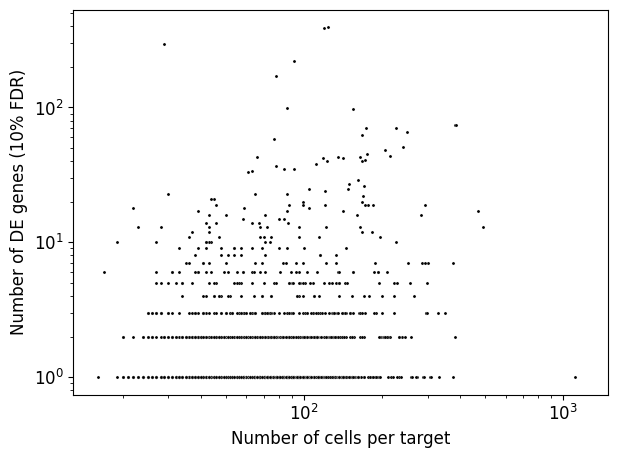

In [241]:
sns.scatterplot(
    data=de_counts,
    x='n_cells_target',
    y='n_total_de_genes',
    color='black', s=5
)
plt.xlabel('Number of cells per target', fontsize=12)
plt.ylabel('Number of DE genes (10% FDR)', fontsize=12)
plt.xscale('log');plt.yscale('log');
plt.tight_layout()

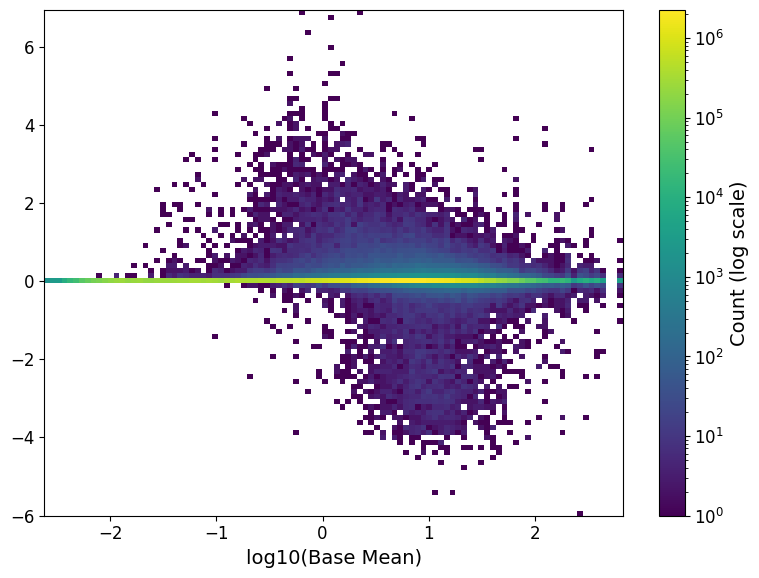

In [242]:
x = adata_de.layers['baseMean'].flatten()
y = adata_de.layers['MASH_PosteriorMean'].flatten()

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

plt.figure(figsize=(8, 6))
h = plt.hist2d(
    np.log10(x), y,
    bins=100,
    norm=matplotlib.colors.LogNorm(),
    cmap='viridis'
)
plt.colorbar(h[3], label='Count (log scale)')
# plt.xscale('log')
plt.xlabel('log10(Base Mean)', fontsize=14)
# plt.ylabel('- log10(Adjusted p-value)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(-10, 20)
plt.tight_layout()
plt.show()

## Number of DE genes per perturbation

In [21]:
# Create categories for number of DE genes with a logical order
de_counts['n_total_genes_category'] = np.nan
de_counts['n_total_genes_category'] = np.where(de_counts['n_total_de_genes'] == 0, 'no effect', de_counts['n_total_genes_category'])
de_counts['n_total_genes_category'] = np.where(de_counts['n_total_de_genes'] == 1, '1 DE gene', de_counts['n_total_genes_category'])
de_counts['n_total_genes_category'] = np.where((de_counts['n_total_de_genes'] > 1) & (de_counts['n_total_de_genes'] <= 10), '2-10 DE genes', de_counts['n_total_genes_category'])
de_counts['n_total_genes_category'] = np.where((de_counts['n_total_de_genes'] > 10), '>10 DE genes', de_counts['n_total_genes_category'])

# Create a categorical type with ordered categories
category_order = ['no effect', '1 DE gene', '2-10 DE genes', '>10 DE genes']
de_counts['n_total_genes_category'] = pd.Categorical(
    de_counts['n_total_genes_category'],
    categories=category_order,
    ordered=True
)

de_counts['ontarget_effect_category'] = 'on-target KD'
de_counts['ontarget_effect_category'] = np.where(~de_counts['ontarget_significant'], 'no on-target KD', de_counts['ontarget_effect_category'])
de_counts['ontarget_effect_category'] = np.where(de_counts['offtarget_flag'], 'putative off-target', de_counts['ontarget_effect_category'])

# Create a bar plot of the value counts
# Group by both ontarget_significant and category
grouped_counts = de_counts.groupby(['n_total_genes_category', 'ontarget_effect_category']).size().reset_index(name='count')
grouped_counts = grouped_counts.pivot(index='n_total_genes_category', columns='ontarget_effect_category', values='count').fillna(0)

# Define a more visually distinct and colorblind-friendly palette
colors = {'on-target KD': '#7570b3', 'putative off-target':'#1b9e77', 'no on-target KD': '#d95f02'}

plt.figure(figsize=(10, 6))
ax = grouped_counts.plot(kind='bar', color=colors.values(), stacked=True)
plt.xlabel('Category', fontsize=12)
plt.ylabel('# perturbations', fontsize=12)
plt.title('Distribution of DE genes per target', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Perturbation type', frameon=False);
# plt.legend(['Off-target', 'On-target'], title='Effect type')
plt.tight_layout();

# Add count labels on top of each bar
for i, total in enumerate(grouped_counts.sum(axis=1)):
    ax.text(i, total + 50, str(int(total)), ha='center', fontsize=10);

KeyError: 'ontarget_significant'

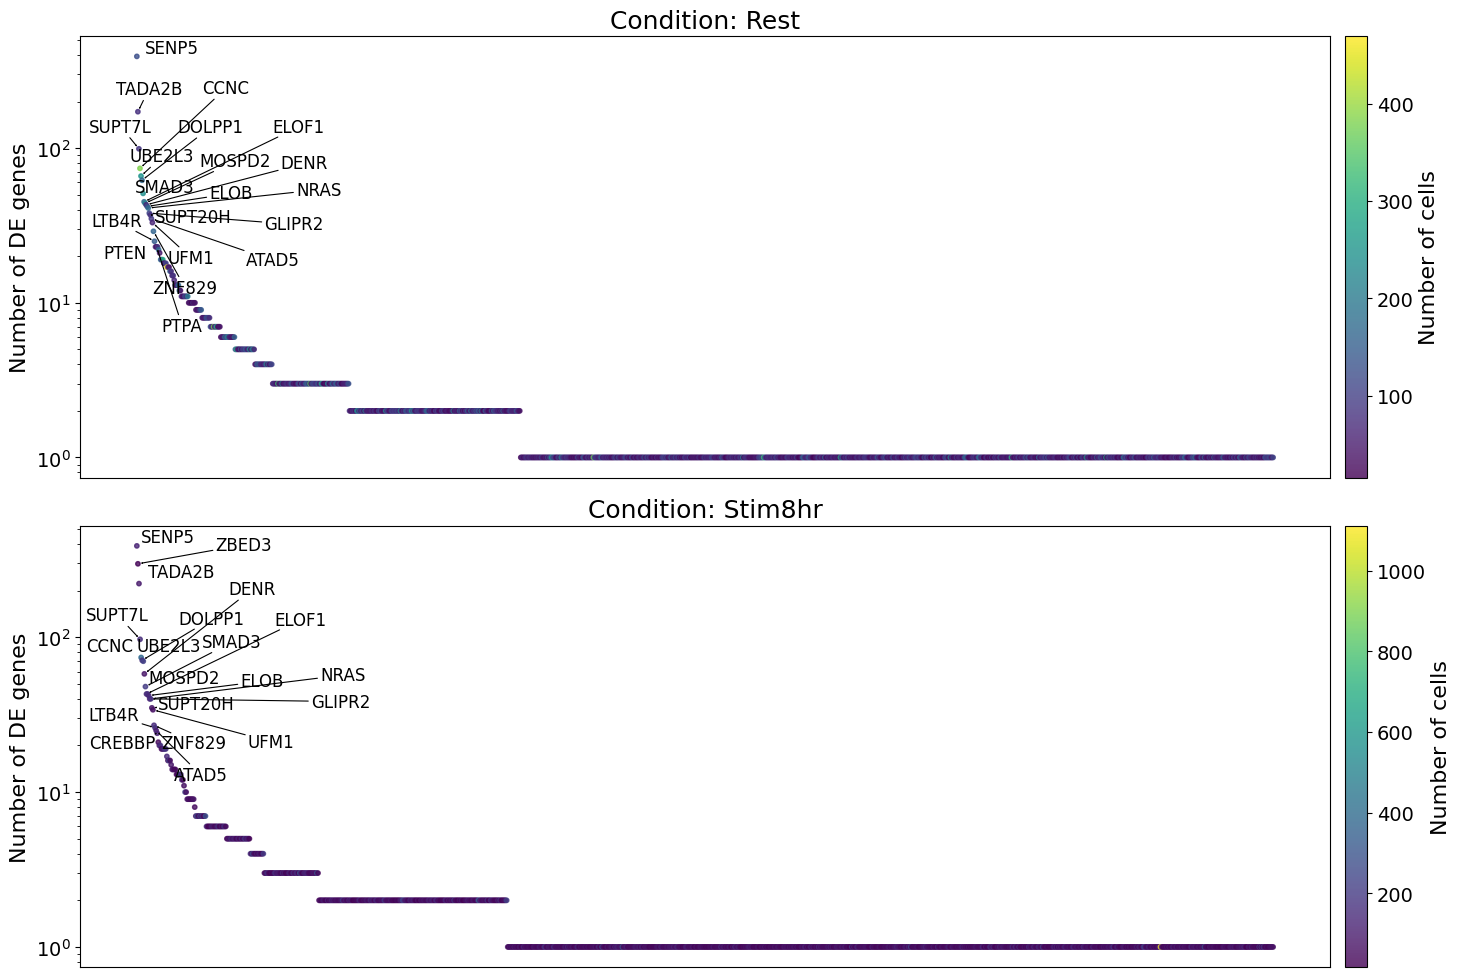

In [278]:
from adjustText import adjust_text

plt.figure(figsize=(16, 10))

for condition in ['Rest', 'Stim8hr']:
    plt.subplot(2, 1, 1 if condition == 'Rest' else 2)
    
    # Filter data for current condition
    condition_df = de_counts[de_counts['condition'] == condition].sort_values('n_total_de_genes', ascending=False)
    condition_df = condition_df[condition_df['n_total_de_genes'] > 0]
    
    if len(condition_df) > 0:
        scatter = plt.scatter(range(len(condition_df)), condition_df['n_total_de_genes'].values, 
                             c=condition_df['n_cells_target'], cmap='viridis', alpha=0.8, s=10)
        cbar = plt.colorbar(scatter, label='Number of cells', pad=0.01)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('Number of cells', fontsize=16)
        
        plt.ylabel('Number of DE genes', fontsize=16)
        plt.title(f'Condition: {condition}', fontsize=18)
        plt.yscale('log')
        plt.xticks([])
        plt.yticks(fontsize=14)
        
        # Get top 20 targets with most DE genes
        top20_targets = condition_df.head(20)
        
        # Create annotations for top targets
        texts = []
        for i, row in top20_targets.iterrows():
            idx = condition_df.index.get_loc(i)
            texts.append(plt.text(idx, row['n_total_de_genes'], row.target_name, fontsize=12))
        
        # Use adjustText to prevent overlapping labels
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.8))
    else:
        plt.text(0.5, 0.5, f"No DE genes for condition: {condition}", 
                 horizontalalignment='center', verticalalignment='center', fontsize=16)

plt.tight_layout()

In [292]:
from DE_analysis_utils import *

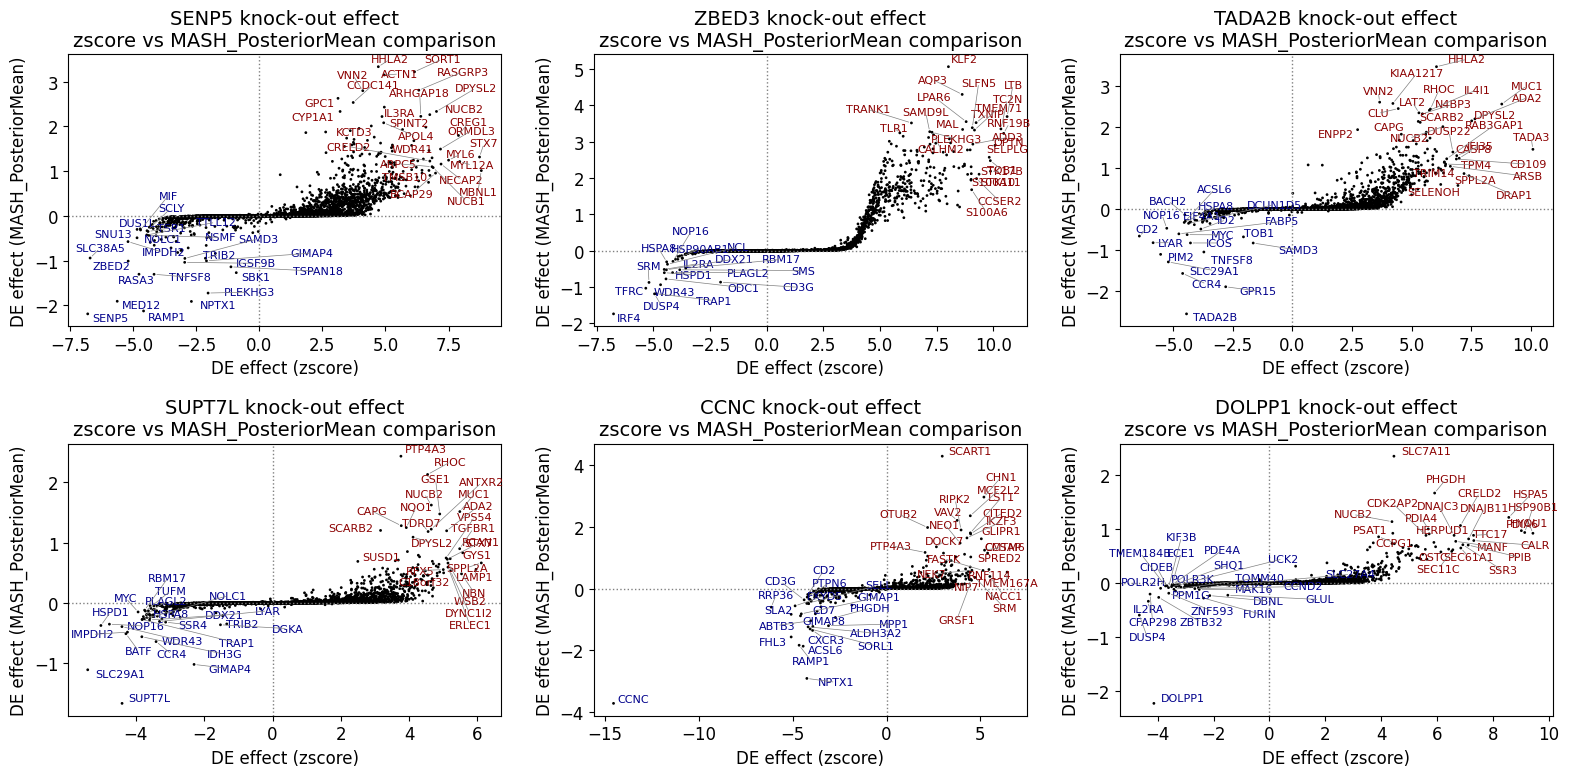

In [293]:
adata_de.var_names = adata_de.var['gene_name'].values
top_gs = condition_df.sort_values('n_total_de_genes', ascending=False)['target_name'][0:6].tolist()

# Create a figure with 3 columns and 2 rows
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()  # Flatten to easily iterate through subplots

# Plot each of the top 6 genes in its own subplot
for i, g in enumerate(top_gs):
    _, res = plot_effect_comparison(
        adata_de, 
        comparison_params = {
            'target_contrast_gene_name':[g],
            'culture_condition':['Stim8hr'],
            'stat':['zscore','MASH_PosteriorMean']
        },
        ax = axs[i]
    )

plt.tight_layout()

## Compare to Freimer arrayed RNA-seq

In [260]:
freimer_df = pd.read_csv('/mnt/oak/users/emma/data/Supplementary_Data_1_RNA_Seq_results.csv')
freimer_kos = [x.replace(" KO", '') for x in freimer_df['sample'].unique().tolist()]
common_perturbations = np.intersect1d(freimer_kos, adata_de.obs['target_contrast_gene_name'])

In [261]:
adata_de.var_names = adata_de.var['gene_ids'].values

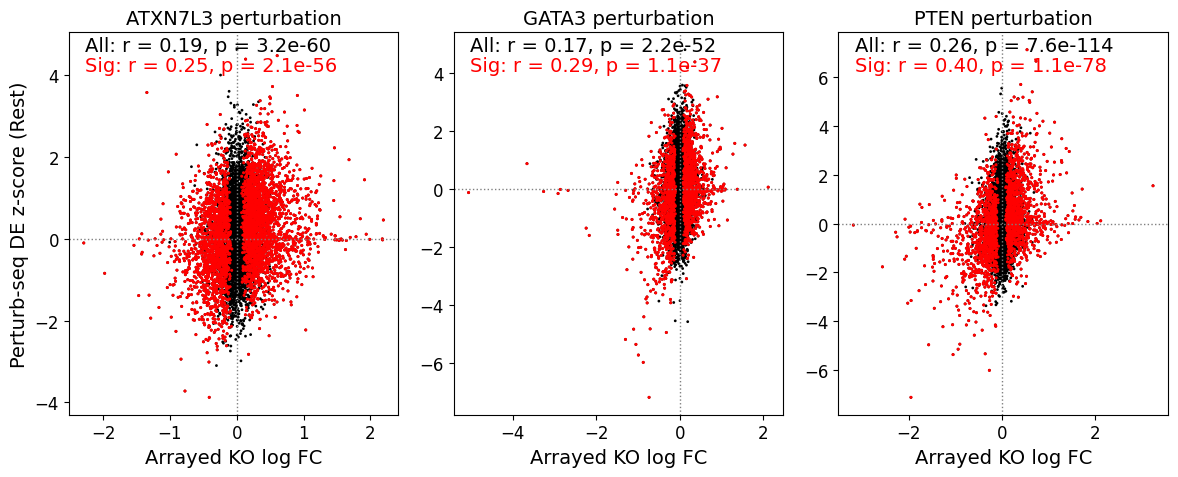

In [268]:
import scipy
import matplotlib.pyplot as plt

# Create a figure with subplots for all common perturbations
fig, axes = plt.subplots(1, len(common_perturbations), figsize=(12, 5))

# If there's only one common perturbation, make axes iterable
if len(common_perturbations) == 1:
    axes = [axes]

for i, g in enumerate(common_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = gwt_effect_g.columns.str.split("_").str[1]
    freimer_effect_g = freimer_df[freimer_df['sample'] == f'{g} KO'].set_index('ens_id')[['logFC']]
    freimer_effect_g['signif'] = freimer_df[freimer_df['sample'] == f'{g} KO'].set_index('ens_id')['adj.P.Val'] < 0.1

    concat_df = pd.concat([freimer_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['logFC'], concat_df['Rest'])
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[concat_df['signif']]['logFC'], 
        concat_df[concat_df['signif']]['Rest']
    ) if sum(concat_df['signif']) > 1 else (float('nan'), float('nan'))

    # Create scatter plot for Rest condition
    sns.scatterplot(data=concat_df, x='logFC', y='Rest', s=4, edgecolor='none', color='black', ax=axes[i])
    sns.scatterplot(data=concat_df[concat_df['signif']], x='logFC', y='Rest', s=5, edgecolor='none', color='red', ax=axes[i])

    # Add correlation information as text
    axes[i].annotate(f'All: r = {rest_corr:.2f}, p = {rest_pval:.1e}', 
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)
    if not np.isnan(rest_signif_corr):
        axes[i].annotate(f'Sig: r = {rest_signif_corr:.2f}, p = {rest_signif_pval:.1e}', 
                    xy=(0.05, 0.90), xycoords='axes fraction', fontsize=14, color='red')

    # Add dotted lines for x and y axes
    axes[i].axhline(y=0, color='gray', linestyle=':', linewidth=1)
    axes[i].axvline(x=0, color='gray', linestyle=':', linewidth=1)
    
    # Set title and labels
    axes[i].set_title(f'{g} perturbation', fontsize=14)
    
    # Only add y-label for the first subplot
    if i == 0:
        axes[i].set_ylabel('Perturb-seq DE z-score (Rest)', fontsize=14)
    else:
        axes[i].set_ylabel('')
    
    axes[i].set_xlabel('Arrayed KO log FC', fontsize=14)

plt.tight_layout()
plt.show()

## Compare effects in 2 conditions

In [269]:
# Create a dataframe to store correlation results
correlation_results = pd.DataFrame(columns=['target_name', 'correlation', 'pvalue'])

for g in adata_de.obs['target_contrast_gene_name'].unique():
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore').dropna()
    gwt_effect_g.columns = gwt_effect_g.columns.str.split("_").str[1]
    # gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore').dropna()
    # gwt_effect_g.columns = gwt_effect_g.columns.str.split("_").str[1]
    r2, pval = scipy.stats.pearsonr(gwt_effect_g['Stim8hr'], gwt_effect_g['Rest'])
    
    # Add results to the dataframe
    correlation_results = pd.concat([correlation_results, pd.DataFrame({
        'target_name': [g],
        'correlation': [r2],
        'pvalue': [pval]
    })], ignore_index=True)


n_cells_df = de_counts.pivot(columns='condition', index='target_name',values='n_cells_target').reset_index().rename({'Rest':'n_cells_Rest', 'Stim8hr':'n_cells_Stim8hr'}, axis=1)
n_de_genes_df = de_counts.pivot(columns='condition', index='target_name',values='n_total_de_genes').reset_index().rename({'Rest':'n_de_genes_Rest', 'Stim8hr':'n_de_genes_Stim8hr'}, axis=1)

correlation_results = pd.merge(pd.merge(correlation_results, n_de_genes_df), n_cells_df)

/tmp/ipykernel_3528334/2162817219.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, pd.DataFrame({


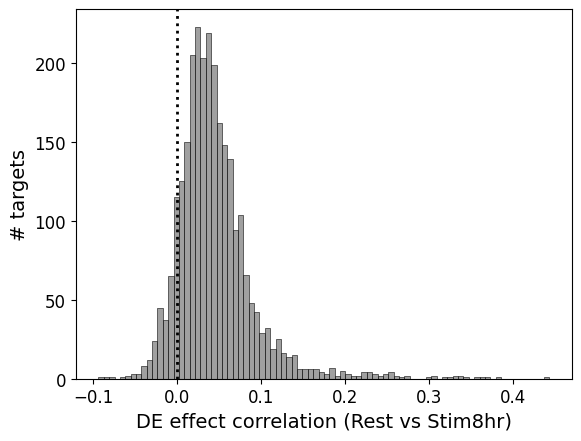

In [270]:
sns.histplot(data=correlation_results, x='correlation', color='grey');
plt.axvline(x=0, color='black', linestyle=':', linewidth=2)
plt.xlabel('DE effect correlation (Rest vs Stim8hr)', fontsize=14)
plt.ylabel('# targets', fontsize=14);

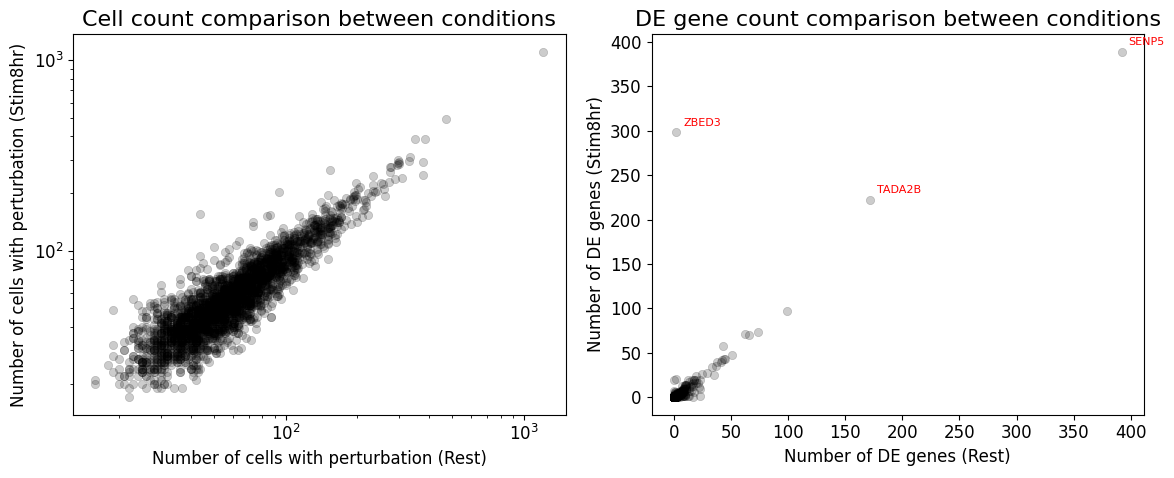

In [271]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Cell counts comparison
sns.scatterplot(data=correlation_results, x='n_cells_Rest', y='n_cells_Stim8hr', 
                alpha=0.2, edgecolor=None, color='black', ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of cells with perturbation (Rest)', fontsize=12)
ax1.set_ylabel('Number of cells with perturbation (Stim8hr)', fontsize=12)
ax1.set_title('Cell count comparison between conditions')
# # Add dotted diagonal line
# ax1.plot([1, 10000], [1, 10000], 'k:', alpha=0.7)  # Diagonal line from (1,1) to (10000,10000)

# Second subplot: DE genes comparison
sns.scatterplot(data=correlation_results, x='n_de_genes_Rest', y='n_de_genes_Stim8hr', 
                alpha=0.2, edgecolor=None, color='black', ax=ax2)
ax2.set_xlabel('Number of DE genes (Rest)', fontsize=12)
ax2.set_ylabel('Number of DE genes (Stim8hr)', fontsize=12)
ax2.set_title('DE gene count comparison between conditions')

# Identify genes with >200 DE genes in any condition
genes_to_annotate = correlation_results[(correlation_results['n_de_genes_Rest'] > 200) | 
                                       (correlation_results['n_de_genes_Stim8hr'] > 200)]

# Annotate these genes in the second plot
for _, row in genes_to_annotate.iterrows():
    ax2.annotate(row['target_name'], 
                xy=(row['n_de_genes_Rest'], row['n_de_genes_Stim8hr']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, color='red')

plt.tight_layout()
# plt.xscale('log');plt.yscale('log');

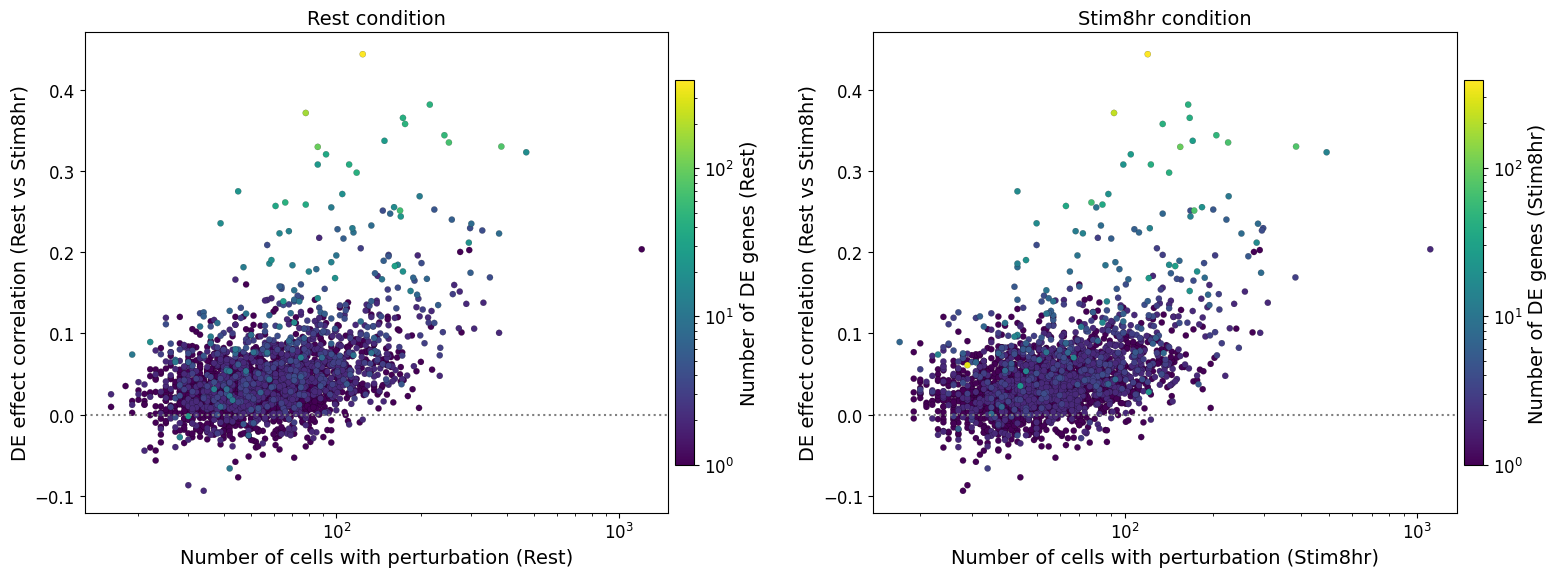

In [274]:
# Sort data so points with most DE genes are plotted on top
# Sort data for both conditions
sorted_data_stim = correlation_results.sort_values('n_de_genes_Stim8hr', ascending=True)
sorted_data_rest = correlation_results.sort_values('n_de_genes_Rest', ascending=True)

# Create a log-normalized color scale for the DE genes
from matplotlib.colors import LogNorm

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Rest condition
scatter1 = ax1.scatter(sorted_data_rest['n_cells_Rest'], sorted_data_rest['correlation'],
                     c=sorted_data_rest['n_de_genes_Rest']+1, s=20, alpha=1, linewidths=0.1,
                     edgecolor='black', cmap='viridis', 
                     norm=LogNorm(vmin=1, vmax=sorted_data_rest['n_de_genes_Rest'].max())
                     )

ax1.axhline(0, color='grey', linestyle=':')
ax1.set_xscale('log')
ax1.set_xlabel('Number of cells with perturbation (Rest)', fontsize=14)
ax1.set_ylabel('DE effect correlation (Rest vs Stim8hr)', fontsize=14)
ax1.set_title('Rest condition', fontsize=14)
plt.colorbar(scatter1, ax=ax1, label='Number of DE genes (Rest)', pad=0.01, 
             orientation='vertical', shrink=0.8, aspect=20)

# Second subplot: Stim8hr condition
scatter2 = ax2.scatter(sorted_data_stim['n_cells_Stim8hr'], sorted_data_stim['correlation'],
                     c=sorted_data_stim['n_de_genes_Stim8hr']+1, s=20, alpha=1, linewidths=0.1,
                     edgecolor='black', cmap='viridis', 
                     norm=LogNorm(vmin=1, vmax=sorted_data_stim['n_de_genes_Stim8hr'].max())
                     )

ax2.axhline(0, color='grey', linestyle=':')
ax2.set_xscale('log')
ax2.set_xlabel('Number of cells with perturbation (Stim8hr)', fontsize=14)
ax2.set_ylabel('DE effect correlation (Rest vs Stim8hr)', fontsize=14)
ax2.set_title('Stim8hr condition', fontsize=14)
plt.colorbar(scatter2, ax=ax2, label='Number of DE genes (Stim8hr)', pad=0.01, 
             orientation='vertical', shrink=0.8, aspect=20)

plt.tight_layout()


## Incoming vs Outgoing effects

In [36]:
targets_de_counts = get_de_stats(adata_de, signif_col='MASH_lfsr', alpha=0.1, axis='targets')
genes_de_counts = get_de_stats(adata_de, signif_col='MASH_lfsr', alpha=0.1, axis='genes')

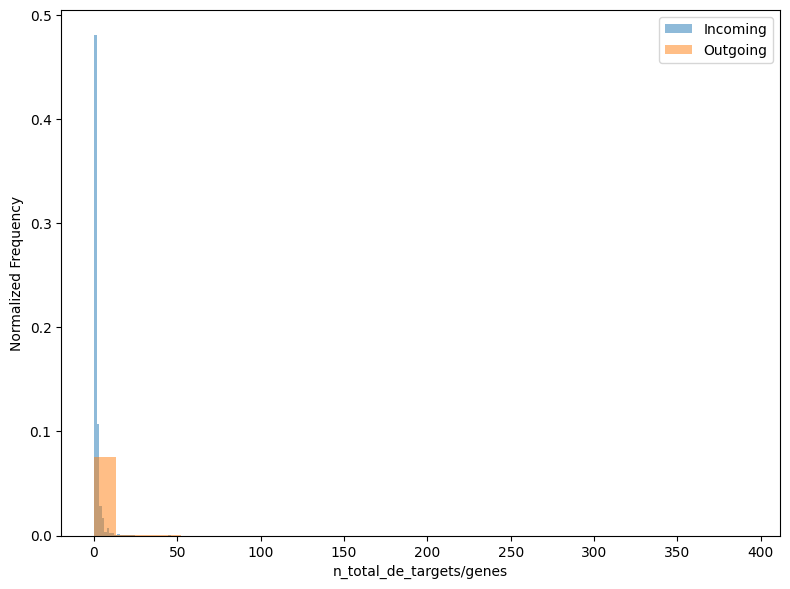

In [18]:
# Create a figure with 1 subplot
plt.figure(figsize=(8, 6))

# Plot histogram of genes affected by perturbations (normalized)
plt.hist(genes_de_counts['n_total_de_targets'], 
         bins=30, 
         alpha=0.5, 
         density=True,
         label='Incoming')

# Plot histogram of perturbations affecting genes (normalized)
plt.hist(targets_de_counts['n_total_de_genes'], 
         bins=30, 
         alpha=0.5, 
         density=True,
         label='Outgoing')

plt.xlabel('n_total_de_targets/genes')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.tight_layout()

In [37]:
# Merge the genes and targets counts for the same gene
targets_de_counts['gene_id'] = targets_de_counts['target_contrast']

# Merge the dataframes on gene_id
merged_counts = pd.merge(
    genes_de_counts[['gene_id', 'gene_name', 'n_total_de_targets']], 
    targets_de_counts[['gene_id', 'n_total_de_genes', 'condition']],
    on='gene_id',
    how='outer',
    suffixes=('_incoming', '_outgoing')
)

# Fill NaN values with 0 for genes that don't have both incoming and outgoing effects
merged_counts['n_total_de_targets'] = merged_counts['n_total_de_targets'].fillna(0).astype(int)
merged_counts['n_total_de_genes'] = merged_counts['n_total_de_genes'].fillna(0).astype(int)
merged_counts

gene_id gene_name  n_total_de_targets  n_total_de_genes  \
0                AKAP2       NaN                   0                 1   
1                AKAP2       NaN                   0                 1   
2      ENSG00000000419      DPM1                   1                 0   
3      ENSG00000000419      DPM1                   1                 1   
4      ENSG00000000460  C1orf112                   0                 0   
...                ...       ...                 ...               ...   
11905             OCLM       NaN                   0                 0   
11906            SEPT6       NaN                   0                 1   
11907            SEPT6       NaN                   0                 1   
11908          SMIM11B       NaN                   0                 0   
11909          SMIM11B       NaN                   0                 0   

      condition  
0          Rest  
1       Stim8hr  
2          Rest  
3       Stim8hr  
4           NaN  
...         ...  
11905      Rest  
11906   Stim8hr  
11907      Rest  
11908      Rest  
11909   Stim8hr  

[11910 rows x 5 columns]

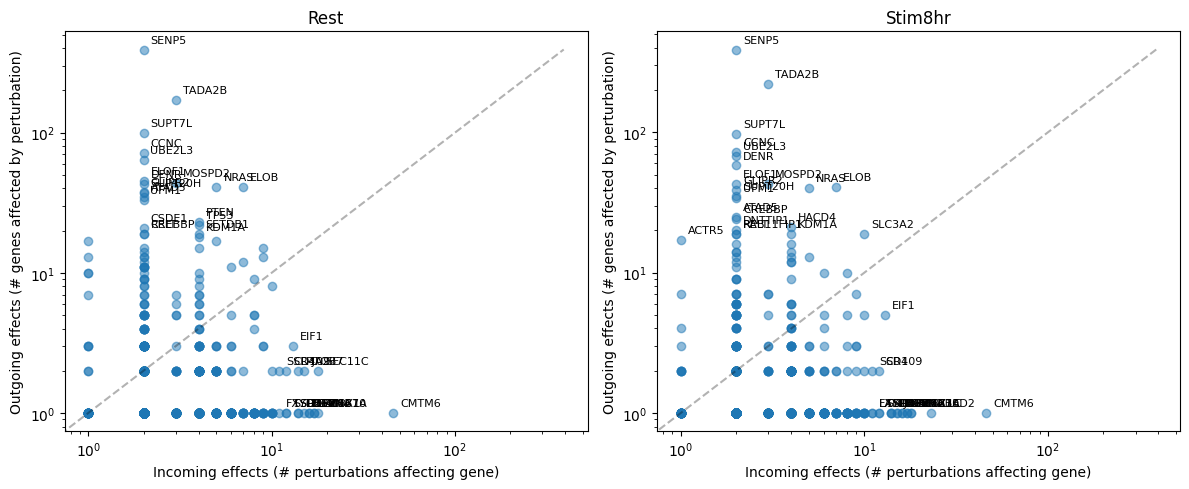

In [38]:
# Split the data by condition using the condition column
rest_data = merged_counts[merged_counts['condition'] == 'Rest']
stim_data = merged_counts[merged_counts['condition'] == 'Stim8hr']

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Rest condition
ax1.scatter(
    rest_data['n_total_de_targets'], 
    rest_data['n_total_de_genes'],
    alpha=0.5
)
ax1.set_xlabel('Incoming effects (# perturbations affecting gene)')
ax1.set_ylabel('Outgoing effects (# genes affected by perturbation)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Rest')

# Add diagonal line for Rest
max_val_rest = max(rest_data['n_total_de_targets'].max(), rest_data['n_total_de_genes'].max())
ax1.plot([0, max_val_rest], [0, max_val_rest], 'k--', alpha=0.3)

# Plot for Stim8hr condition
ax2.scatter(
    stim_data['n_total_de_targets'], 
    stim_data['n_total_de_genes'],
    alpha=0.5
)
ax2.set_xlabel('Incoming effects (# perturbations affecting gene)')
ax2.set_ylabel('Outgoing effects (# genes affected by perturbation)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Stim8hr')

# Add diagonal line for Stim8hr
max_val_stim = max(stim_data['n_total_de_targets'].max(), stim_data['n_total_de_genes'].max())
ax2.plot([0, max_val_stim], [0, max_val_stim], 'k--', alpha=0.3)

# Add annotations for interesting genes in each subplot
threshold_incoming_rest = rest_data['n_total_de_targets'].quantile(0.99)
threshold_outgoing_rest = rest_data['n_total_de_genes'].quantile(0.99)

for idx, row in rest_data.iterrows():
    if row['n_total_de_targets'] > threshold_incoming_rest or row['n_total_de_genes'] > threshold_outgoing_rest:
        ax1.annotate(
            row['gene_name'], 
            (row['n_total_de_targets'], row['n_total_de_genes']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )

threshold_incoming_stim = stim_data['n_total_de_targets'].quantile(0.99)
threshold_outgoing_stim = stim_data['n_total_de_genes'].quantile(0.99)

for idx, row in stim_data.iterrows():
    if row['n_total_de_targets'] > threshold_incoming_stim or row['n_total_de_genes'] > threshold_outgoing_stim:
        ax2.annotate(
            row['gene_name'], 
            (row['n_total_de_targets'], row['n_total_de_genes']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )

plt.tight_layout()


## Compare trans-effects

Visualize downstream effects of perturbed genes with strongest effects

In [ ]:
# targets_oi = de_counts[(de_counts.condition == 'Stim8hr') & (de_counts.n_total_de_genes >= 5)].sort_values('n_total_de_genes', ascending=True)[0:100].target_name.tolist()
targets_oi = de_counts[de_counts.condition == 'Stim8hr'].sort_values('n_total_de_genes', ascending=False)[0:50].target_name.tolist()

In [46]:
adata_de.var_names = adata_de.var['gene_name'].values

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


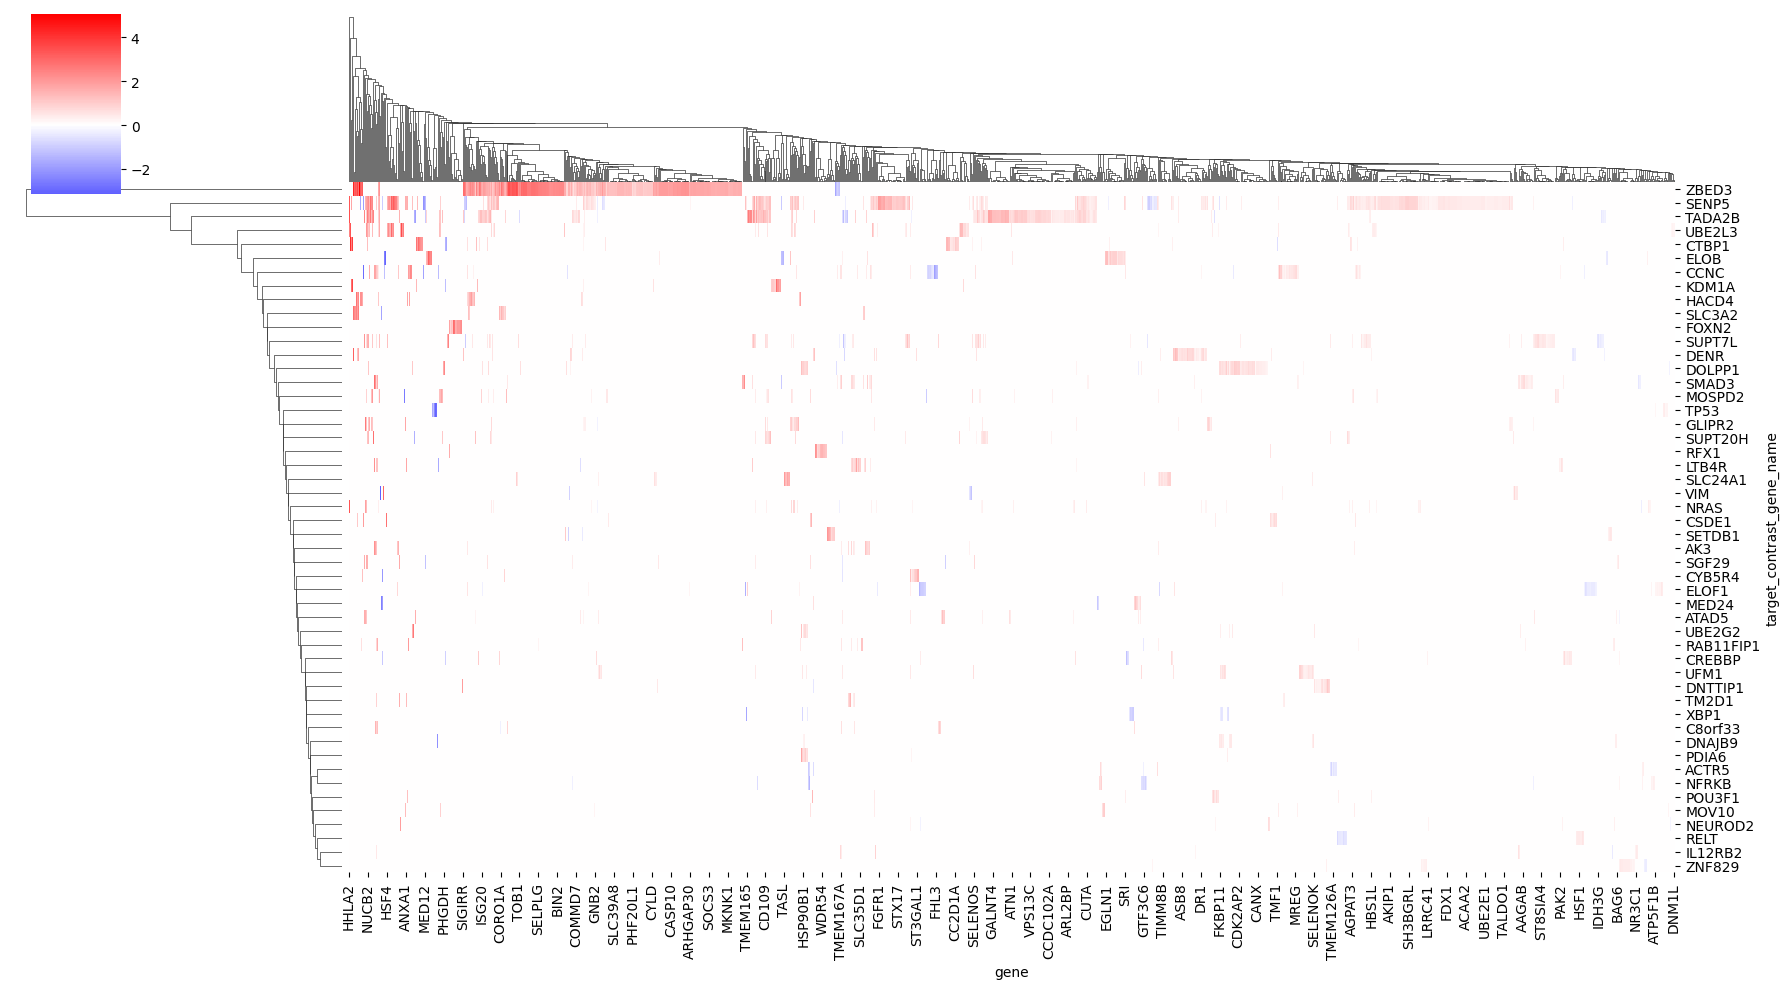

In [48]:
targets_oi = de_counts[de_counts.condition == 'Stim8hr'].sort_values('n_total_de_genes', ascending=False)[0:50].target_name.tolist()

targets = targets_oi 
genes = None
cond = 'Stim8hr'
effect_stat = 'MASH_PosteriorMean'
signif_stat = 'MASH_lfsr'
signif_alpha = 0.1
filter_signif = True
mask_targets = True

res_df = get_DE_results_long(
    adata_de, 
    targets=targets, genes=genes,
    effect_estimates=[effect_stat], signif_alpha=signif_alpha, signif_estimate=signif_stat)
res_df = res_df[res_df['culture_condition'] == cond]

if mask_targets:
    res_df.loc[res_df['target_contrast_gene_name'] == res_df['gene'], effect_stat] = 0
    res_df.loc[res_df['target_contrast_gene_name'] == res_df['gene'], 'significant'] = False

if filter_signif:
    res_df = res_df[res_df['significant']]
else:
    keep_genes = res_df.gene[res_df['significant']].unique()
    keep_targets = res_df.target_contrast_gene_name[res_df['significant']].unique()
    res_df = res_df[res_df.gene.isin(keep_genes) & res_df.target_contrast_gene_name.isin(keep_targets)]

pl_df = res_df.pivot(columns='target_contrast_gene_name', index='gene', values=effect_stat)

sns.clustermap(pl_df.T.fillna(0), cmap='bwr', center=0, yticklabels=True, figsize=(18,10))

## Shared effects between perturbations

In [65]:
# Restict to perturbations with at least 2 significant DE genes
targets = de_counts[(de_counts.condition == 'Stim8hr') & (de_counts.n_total_de_genes > 1)].target_name.tolist()
genes = None
cond = 'Stim8hr'
effect_stat = 'MASH_PosteriorMean'
signif_stat = 'MASH_lfsr'
signif_alpha = 0.1
filter_signif = True
mask_targets = True

res_df = get_DE_results_long(
    adata_de, 
    targets=targets, genes=genes,
    effect_estimates=[effect_stat], signif_alpha=signif_alpha, signif_estimate=signif_stat)
res_df = res_df[res_df['culture_condition'] == cond]

if mask_targets:
    res_df.loc[res_df['target_contrast_gene_name'] == res_df['gene'], effect_stat] = 0
    res_df.loc[res_df['target_contrast_gene_name'] == res_df['gene'], 'significant'] = False

if filter_signif:
    res_df = res_df[res_df['significant']]
else:
    keep_genes = res_df.gene[res_df['significant']].unique()
    keep_targets = res_df.target_contrast_gene_name[res_df['significant']].unique()
    res_df = res_df[res_df.gene.isin(keep_genes) & res_df.target_contrast_gene_name.isin(keep_targets)]

pl_df = res_df.pivot(columns='target_contrast_gene_name', index='gene', values=effect_stat)
pl_df = np.sign(pl_df).fillna(0)

In [53]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score
from collections import defaultdict

def compute_shared_effects(pl_df):
    """
    Compute shared effects between perturbations (same gene & same sign)
    Ignores shared zeros
    
    Args:
        pl_df: DataFrame with genes as rows and perturbations as columns
        
    Returns:
        DataFrame with perturbations as rows and columns, values are number of shared effects
    """
    perturbations = pl_df.columns
    n_perturbations = len(perturbations)
    
    # Initialize shared effects matrix
    shared_effects = pd.DataFrame(0, index=perturbations, columns=perturbations)
    
    # Calculate shared effects (same gene, same non-zero effect)
    for i in range(n_perturbations):
        pert1 = perturbations[i]
        
        for j in range(i, n_perturbations):
            pert2 = perturbations[j]
            
            # Extract gene effects for each perturbation
            effects1 = pl_df[pert1]
            effects2 = pl_df[pert2]
            
            # Count shared non-zero effects (same gene, same sign)
            # Both must be non-zero and have the same sign
            shared = sum((effects1 != 0) & (effects2 != 0) & (effects1 == effects2))
            
            # Assign to the matrix (symmetric)
            shared_effects.loc[pert1, pert2] = shared
            shared_effects.loc[pert2, pert1] = shared
    
    return shared_effects

def compute_similarity_matrix(pl_df, shared_effects):
    """
    Compute similarity matrix using Jaccard similarity
    
    Args:
        pl_df: DataFrame with genes as rows and perturbations as columns
        shared_effects: DataFrame with number of shared effects
        
    Returns:
        DataFrame with Jaccard similarity between perturbations
    """
    perturbations = pl_df.columns
    similarity = pd.DataFrame(0.0, index=perturbations, columns=perturbations)
    
    for i, pert1 in enumerate(perturbations):
        for j, pert2 in enumerate(perturbations):
            # Count non-zero effects for each perturbation
            nonzero1 = (pl_df[pert1] != 0).sum()
            nonzero2 = (pl_df[pert2] != 0).sum()
            
            # Get shared effects
            shared = shared_effects.loc[pert1, pert2]
            
            # Jaccard similarity: intersection / union
            # Union = total non-zero effects in both perturbations minus shared effects
            union = nonzero1 + nonzero2 - shared
            
            # Calculate Jaccard similarity
            similarity.loc[pert1, pert2] = shared / union if union > 0 else 0
    
    return similarity

def group_perturbations(similarity_matrix, threshold=0.5):
    """
    Group perturbations based on similarity
    
    Args:
        similarity_matrix: DataFrame with similarity between perturbations
        threshold: Similarity threshold for grouping
        
    Returns:
        Dictionary with groups as keys and lists of perturbations as values
    """
    # Convert similarity to distance (1 - similarity)
    distance_matrix = 1 - similarity_matrix
    
    # Perform hierarchical clustering
    Z = linkage(distance_matrix.values, method='average')
    
    # Form clusters
    clusters = fcluster(Z, threshold, criterion='distance')
    
    # Group perturbations by cluster
    groups = defaultdict(list)
    for i, cluster_id in enumerate(clusters):
        groups[cluster_id].append(similarity_matrix.index[i])
    
    return dict(groups)

def visualize_similarity(similarity_matrix, groups=None):
    """
    Visualize similarity matrix as a heatmap
    
    Args:
        similarity_matrix: DataFrame with similarity between perturbations
        groups: Optional dictionary with grouped perturbations
    """
    plt.figure(figsize=(10, 8))
    
    # If groups are provided, reorder the matrix to show groups together
    if groups:
        # Flatten groups into a list preserving order
        ordered_perturbations = []
        for group_id in sorted(groups.keys()):
            ordered_perturbations.extend(groups[group_id])
        
        # Reindex the similarity matrix
        similarity_matrix = similarity_matrix.loc[ordered_perturbations, ordered_perturbations]
    
    # Create heatmap
    sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu", 
                vmin=0, vmax=1, fmt=".2f", linewidths=0.5)
    
    plt.title("Similarity between Perturbations")
    plt.tight_layout()
    plt.show()

def analyze_perturbation_effects(pl_df, threshold=0.5, visualize=True):
    """
    Main function to analyze perturbation effects
    
    Args:
        pl_df: DataFrame with genes as rows and perturbations as columns
        threshold: Similarity threshold for grouping
        visualize: Whether to visualize the results
        
    Returns:
        groups: Dictionary with groups of perturbations
        shared_effects: DataFrame with number of shared effects
        similarity: DataFrame with similarity between perturbations
    """
    # Compute shared effects
    shared_effects = compute_shared_effects(pl_df)
    print("Shared non-zero effects between perturbations:")
    print(shared_effects)
    
    # Compute similarity matrix
    similarity = compute_similarity_matrix(pl_df, shared_effects)
    print("\nSimilarity matrix (Jaccard index):")
    print(similarity)
    
    # Group perturbations
    groups = group_perturbations(similarity, threshold)
    print("\nGrouped perturbations (threshold = {:.2f}):".format(threshold))
    for group_id, perturbations in groups.items():
        print(f"Group {group_id}: {perturbations}")
    
    # Visualize if requested
    if visualize:
        visualize_similarity(similarity, groups)
    
    return groups, shared_effects, similarity

# Analyze perturbation effects
shared_effects = compute_shared_effects(pl_df)
similarity = compute_similarity_matrix(pl_df, shared_effects)
np.fill_diagonal(shared_effects.values, 0)
np.fill_diagonal(similarity.values, 0)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Text(0.5, 1.0, 'Fraction of shared DE genes\n(Jaccard Index)')

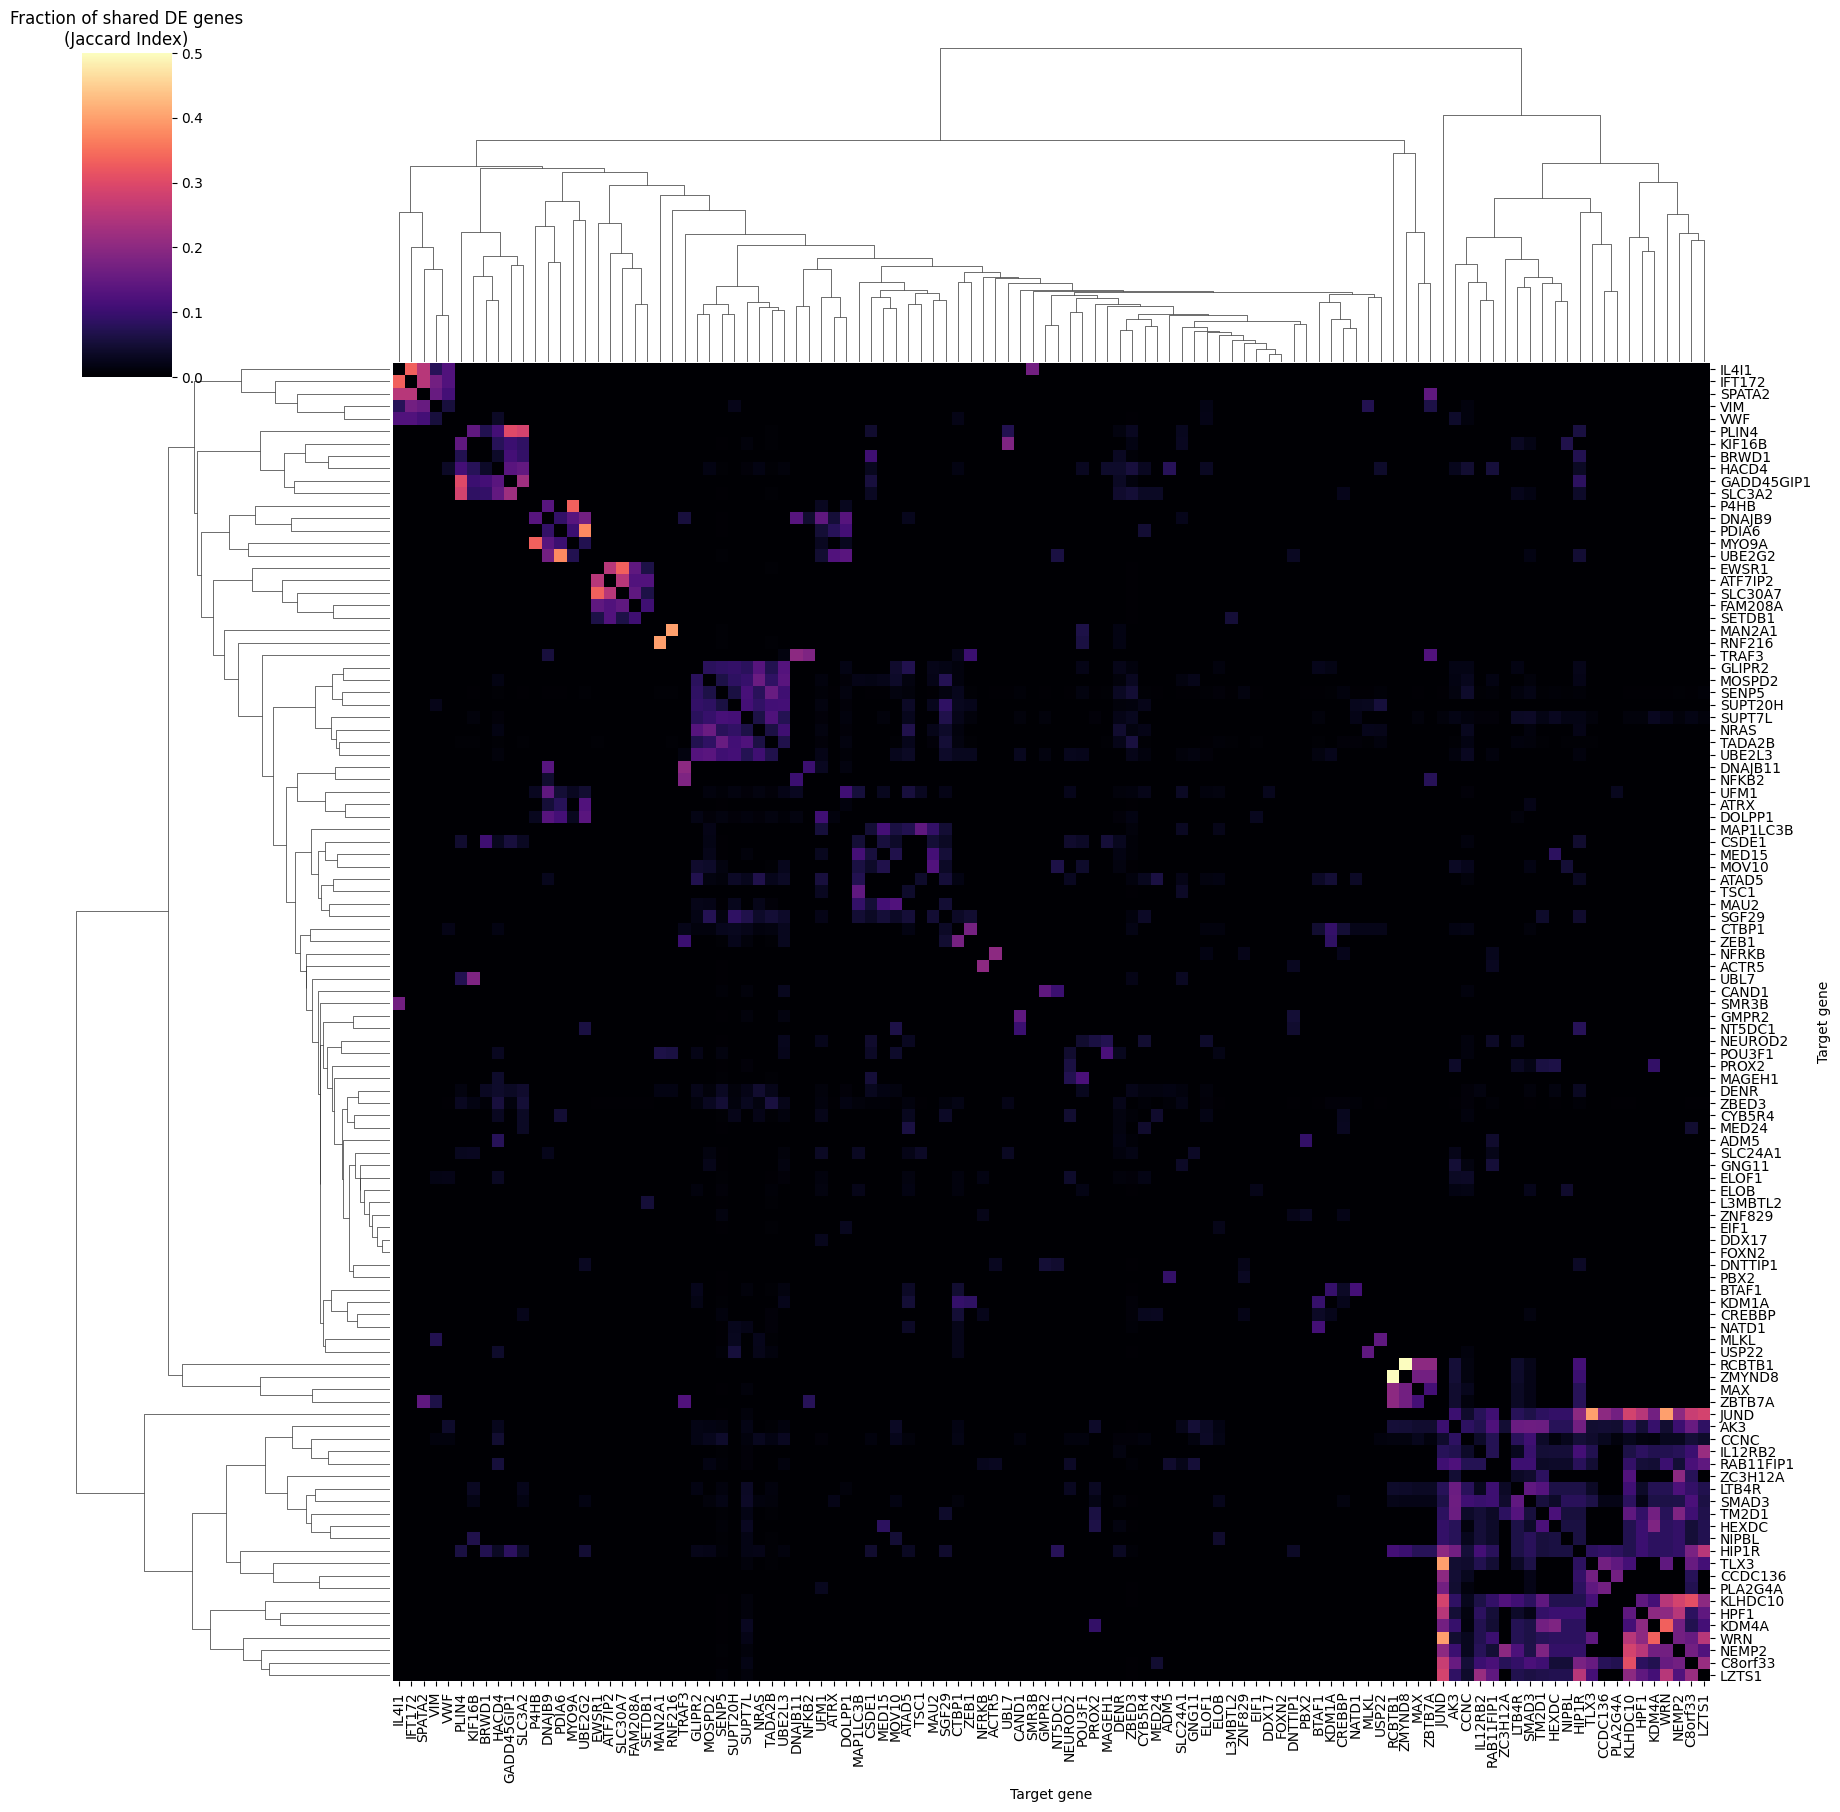

In [87]:
from scipy import cluster
# Generate the clustermap
clustermap = sns.clustermap(
    similarity.loc[shared_effects.sum(1) > 5, shared_effects.sum(1) > 5],
    method='complete', metric='euclidean',
    figsize=(18,18), 
    xticklabels=True, yticklabels=True,
    cmap='magma'
)

# Add proper axis labels to the main heatmap
clustermap.ax_heatmap.set_xlabel('Target gene')
clustermap.ax_heatmap.set_ylabel('Target gene')
plt.title('Fraction of shared DE genes\n(Jaccard Index)')

<Figure size 1000x600 with 0 Axes>

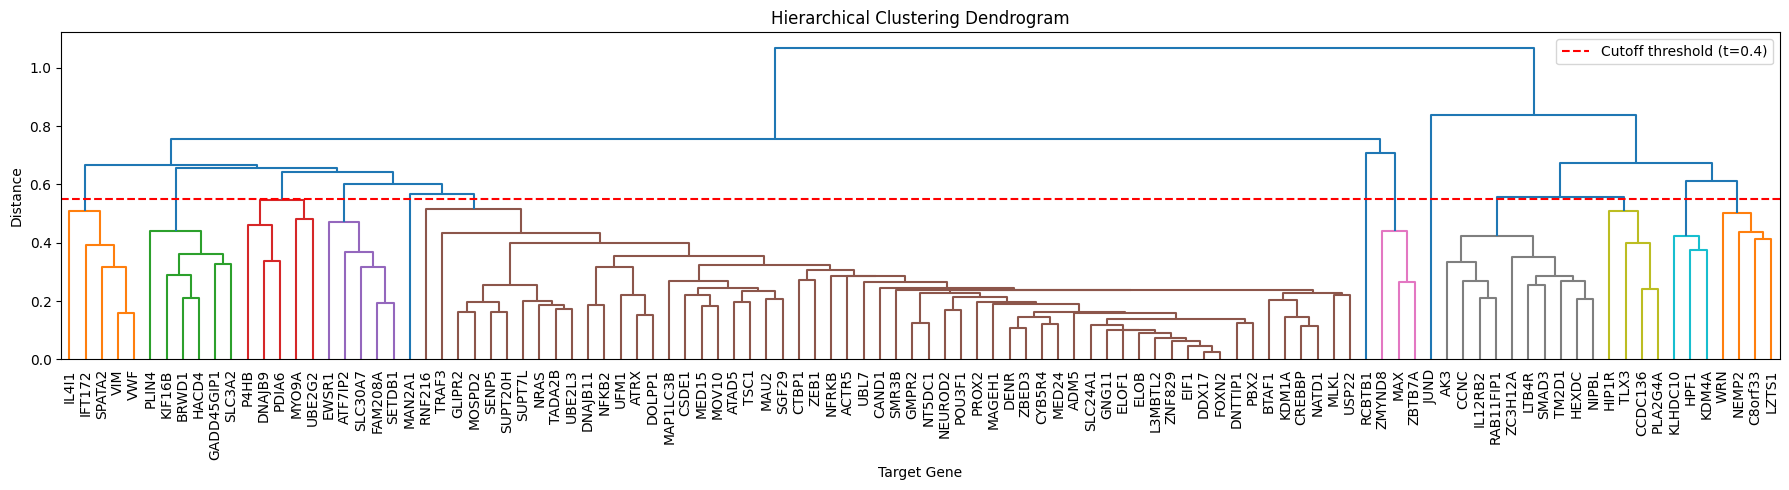

In [293]:
# Extract the clusters from the dendrogram
row_linkage = clustermap.dendrogram_row.linkage

# Plot the dendrogram separately to visualize the clustering
plt.figure(figsize=(10, 6))
cutoff = 0.55
# Get the gene names for the filtered genes
filtered_genes = similarity.loc[shared_effects.sum(1) > 5].index
# Create the dendrogram with gene names as labels
plt.figure(figsize=(18,5))
dendrogram = cluster.hierarchy.dendrogram(
    row_linkage, 
    color_threshold=cutoff,
    labels=filtered_genes
)
plt.axhline(y=cutoff, color='r', linestyle='--', label='Cutoff threshold (t=0.4)')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Target Gene')
plt.ylabel('Distance')
plt.legend()
plt.xticks(rotation=90, fontsize=10)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Apply clustering with the chosen cutoff
row_clusters = cluster.hierarchy.fcluster(row_linkage, t=cutoff, criterion='distance')

# Create a dictionary mapping cluster IDs to gene names
cluster_dict = {}
filtered_genes = similarity.loc[shared_effects.sum(1) > 5].index
for i, gene in enumerate(filtered_genes):
    cluster_id = row_clusters[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(gene)

In [302]:
shared_effects.loc['GLIPR2','MOSPD2']

6

In [99]:
[x for x,v in cluster_dict.items() if len(v) > 1]

[5, 9, 4, 2, 12, 10, 3, 11, 1, 7]

In [298]:
cl = 9
[x for x in cluster_dict[cl] if x in suspects]


[]

Text(0.5, 1.0, 'N shared DE genes\n')

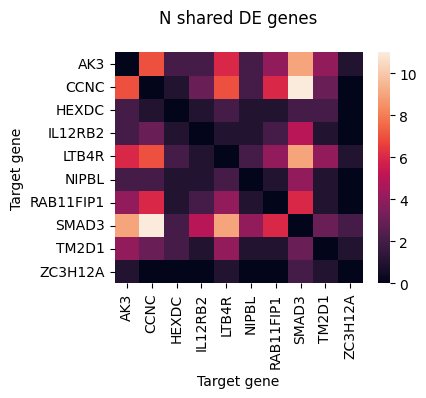

In [299]:
plt.figure(figsize = (4,3));
sns.heatmap(shared_effects.loc[cluster_dict[cl], cluster_dict[cl]])
# Add proper axis labels to the main heatmap
plt.xlabel('Target gene')
plt.ylabel('Target gene')
plt.title('N shared DE genes\n')

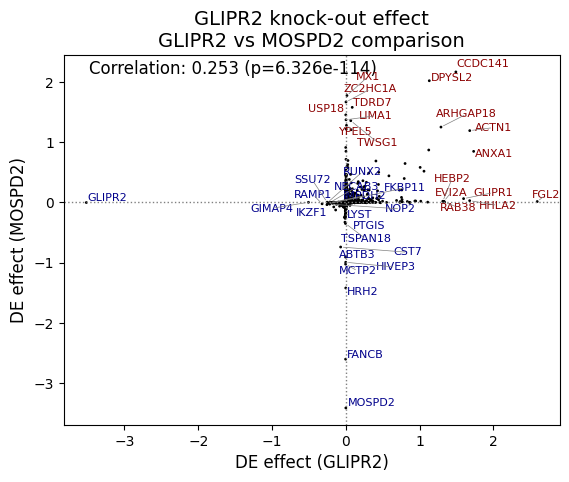

In [303]:
adata_de.var_names = adata_de.var['gene_name'].values

fig, axs = plt.subplots()
res = plot_effect_comparison(
    adata_de, 
    comparison_params = {
        'target_contrast_gene_name':[ 'GLIPR2','MOSPD2'],
        'culture_condition':['Stim8hr'],
        'stat':['MASH_PosteriorMean']
    },
    n_top_genes=10,
    plot_correlation=True,
    ax=axs
    )

In [ ]:
import gseapy as gp

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
# KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**GO_BP_sets}

# gl = cluster_dict[cl]
# background = adata_de.obs['target_contrast_gene_name'].unique().tolist()

gl = res[1].iloc[:, 1].sort_values(ascending=False)[0:20].index.tolist()
background = res[1].index.tolist()

# # run enrichr
enr = gp.enrichr(gene_list=gl,
                gene_sets=GENESETS,
                organism='Human', 
                background=background,
                outdir=None,
                no_plot=True
                )

enr.results[0:10]

Gene_set                                             Term Overlap  \
0  gs_ind_0   Actin Cytoskeleton Reorganization (GO:0031532)    1/25   
1  gs_ind_0      Actin Filament Bundle Assembly (GO:0051017)    1/14   
2  gs_ind_0  Actin Filament Bundle Organization (GO:0061572)    1/12   
3  gs_ind_0         Actin Filament Organization (GO:0007015)    1/48   
4  gs_ind_0    Antiviral Innate Immune Response (GO:0140374)    2/30   
5  gs_ind_0            Apoptotic Cell Clearance (GO:0043277)     1/9   
6  gs_ind_0                   Apoptotic Process (GO:0006915)   1/137   
7  gs_ind_0              Arachidonate Transport (GO:1903963)     1/1   
8  gs_ind_0          Arachidonic Acid Secretion (GO:0050482)     1/1   
9  gs_ind_0              Autophagosome Assembly (GO:0000045)    1/40   

    P-value  Adjusted P-value   Odds Ratio  Combined Score      Genes  
0  0.062643          0.106076    24.199372       67.039439      ANXA1  
1  0.035554          0.080631    43.980057      146.748336      LIMA1  
2  0.030549          0.074611    51.642140      180.148883      LIMA1  
3  0.116967          0.151580    12.444534       26.704236      ACTN1  
4  0.002635          0.043640    36.526790      216.926922  MX1;USP18  
5  0.022996          0.069691    69.895928      263.676910      ANXA1  
6  0.300302          0.324581     4.280361        5.149136        MX1  
7  0.002580          0.043640  1189.461538     7089.006251      ANXA1  
8  0.002580          0.043640  1189.461538     7089.006251      ANXA1  
9  0.098421          0.136606    14.980526       34.732435   MAP1LC3A